# Climate Risk Analysis: Mongolia Dzud and Summer Drought Analysis 2009-2010

## Introduction

Mongolia is highly vulnerable to climate extremes due to its cold continental climate and strong dependence on pastoral livestock subsistence farming. One of the most severe climate hazards affecting the country is *dzud*, a compound winter disaster of varying types, usually characterised by extreme cold, long term or deep snow cover, and ice crusts that prevent livestock from accessing pasture and damage or make infrastructure unusable. Dzud can lead to major livestock losses, threatening rural subsistence farmers and national level food security, further increasing urban struggles with overcrowding and over worked services.

**Types of dzud**
- **White Dzud**: Deep snow covers the ground, burying grass and infrastructure.
- **Black Dzud**: Little persistent snow combined with poor rainfall in the summer, causing little grass on the pastures.
- **Iron dzud**: Icy impenetrable crust forms over the ground, making grass impossible to access.

The 2009-2010 dzud stands out as one of the worst climate disasters in Mongolia's modern history, resulting in the loss of many millions of liverstock and serious socio economic impacts across the entire country. Importantly, dzud risk deos not arise from the winter alone. A summer of poor pasture growth, typically caused by below average rainfall or drought, can leave livestock in a more precarious position going into winter amplifying the potential extremes of the winter.

This notebook analyses the 2009-2010 dzud as a *compound climate event*, starting in the summer 2009 and its precipitation conditions and finishing in the extreme winter spanning 2009-2010. By analysing both phases together, this analysis aims to show the full climatic pathway through which the risk appeared in Mongolia during this period.

**Objectives**
- Assess the precipitation levels and spread in the 2009 summer as a preconditioning factor in dzud risk using satellite rainfall data.  
- Demonstrate the severity of the winter conditions in 2009 and 2010 using temperature and snow related indicators.  
- Compare how the summer and winter of 2009-2010 conditions are against the historical baseline to determine their extremes.    
- Examine spatial patterns of climate stress in Mongolia and illustrate local conditions using Ulaanbaatar as a representative location.  
- Provide a seasonal and compound perspective on climate risk that later supports a comparison with the drought and extreme rainfall risk in Chad.

## Data Sources

This analysis combines both satellite data and reanalysis data to capture the different climatic drivers of dzud risk across seasons and years. Summer conditions, especially those of the pastures and rural areas, are going to be analysed using precipitation data, while winter severity for dzud using temperature and snow variables.

### Primary Sources

**ERA5 Reanalysis (ECMWF)**    
- *Variables*: 
    - 2m air temperature  
    - Snow depth (and/or cover)  
- *Spatial resolution*:     
    - ERA5: ~0.25° x 0.25°  
- *Temporal resolution*:
    - Hourly, being aggregated to daily for this analysis
- *Coverage*:
    - Global
- *Usage in this notebook*:
    - Assessment of the winter severity during 2009-10 dzud
    - Historical baseline comparison of winter conditions
- *Source*:
    - https://cds.climate.copernicus.eu/datasets/

**CHIRPS (Climate Hazards Group InfraRed precipitation with Station Data)**
- *Variables*: 
    - Daily Precipitation
- *Spatial resolution*:  
    - ~0.25° x 0.25°     
- *Temporal resolution*:
    - Daily
- *Coverage*:
    - Global, 1981-Current
- *Usage in this notebook*:
    - Assessment of the summer precipitation conditions (June-October 2009)
    - Historical baseline comparison of summer rainfall
- *Source*:
    - https://data.chc.ucsb.edu/products/CHIRPS-2.0/

### Supplementary Sources

**Country Boundaries**:
- Source: Natural Earth (110m cultural vectors)
- URL: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip
- Purpose: Spatial clipping and visualization

**MODIS Snow Cover (Potentially)**  
- *Variable*: 
    - Snow cover extent  
- *Spatial resolution*: 
    - ~500 m  
- *Temporal resolution*: 
    - Daily  
- *Usage*:  
    - Qualitative validation of snow persistence patterns  
    - Supplementary visualisation of winter snow conditions  
- *Source*:
    - https://modis.gsfc.nasa.gov/data/dataprod/mod10.php

### Data Notes

- The analysis period spans **June 2009 to March 2010**, capturing both summer preconditioning and winter dzud severity.  
- Historical baseline conditions are derived from **1981–2009**, providing a consistent reference period prior to the 2009–2010 event.    
- All datasets are spatially subset to Mongolia’s national boundaries.  
- Temperature is analysed in degrees Celsius and precipitation in millimeters.  
- Seasonal definitions follow climatological relevance rather than calendar years:
  - **Summer**: June–October
  - **Winter**: November–March
- ERA5 data is installed using cdsapi and an API key. This requires prior configuration of the cdsapi and a valid CDS account.
- MODIS may be used to add further clarity and visualisation of specifically 2009-2010 winter, however due to the nature of the dataset, it may be out of the scope of this notebook
- ERA5 data was swapped from originally ERA5-Land data to ERA5 data due to problems with installing into zip files and not netCDF or grib files.

In [1]:
import logging
import sys
from pathlib import Path
import warnings
from contextlib import contextmanager

# Handles Removal of logging and warnings to clean up notebook

for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
for handler in logging.getLogger().handlers[:]:
    logging.getLogger().removeHandler(handler)

logging.basicConfig(level=logging.WARNING, stream=sys.stdout)

ecmwf_logger_name = 'ecmwf.datastores.legacy_client'
ecmwf_logger = logging.getLogger(ecmwf_logger_name)
ecmwf_logger.setLevel(logging.WARNING) 
ecmwf_logger.propagate = False 

@contextmanager
def suppress_stderr():
    old_stderr = sys.stderr
    sys.stderr = open(os.devnull, 'w')
    try:
        yield
    finally:
        sys.stderr.close()
        sys.stderr = old_stderr

warnings.filterwarnings("ignore", category=UserWarning, module="dask")

# Allows calling of config.py while not in same path

project_root = Path.cwd().parent
sys.path.append(str(project_root))

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import rioxarray
from rioxarray.merge import merge_arrays
import matplotlib.colors as colors
from matplotlib.colors import TwoSlopeNorm
import cdsapi
import os
import glob
from config import get_event_dir, get_raw_dir
from shutil import copy2
import requests
from scipy.stats import gamma, norm as stats_norm
from scipy.ndimage import gaussian_filter
from pystac_client import Client
import planetary_computer as pc
from rasterio.enums import Resampling
import time

# Definitions 

bcolor = "darkslategrey"

COUNTRY = "mongolia"
ERA5 = "era5"
CHIRPS = "chirps"

ERA5_DOWNLOAD_YEARS = range(1981, 2011)
ERA5_BASELINE_YEARS = range(1981, 2009)
ERA5_PRIMARY_YEARS = [2009, 2010]

CHIRPS_DOWNLOAD_YEARS = range(1981, 2010)
CHIRPS_BASELINE_YEARS = range(1981, 2009)
CHIRPS_PRIMARY_YEARS = [2009]

# Mongolia Map Clipping

url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url)

mongolia_shape = world[world["NAME"] == "Mongolia"]
mongolia_shape = mongolia_shape.to_crs("EPSG:4326")
mongolia_bounds = mongolia_shape.total_bounds

start = time.time()

# Land Data

catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = catalog.search(
    collections=["esa-worldcover"],
    bbox=mongolia_bounds
)

items = list(search.items())

print(f"PC Search: {time.time() - start:.1f}s")

start = time.time()
signed_items = [pc.sign(item.assets["map"]).href for item in items]

landcover_tiles = []
for href in signed_items:
    tile = rioxarray.open_rasterio(
        href,
        masked=True,
        overview_level=4
    ).squeeze()
    landcover_tiles.append(tile)

print(f"Loading tiles: {time.time() - start:.1f}s")

start = time.time()
landcover = merge_arrays(landcover_tiles)
print(f"Merging: {time.time() - start:.1f}s")

landcover = landcover.rio.set_spatial_dims("x", "y", inplace=False)
mongolia_geom = mongolia_shape.to_crs(landcover.rio.crs)

start = time.time()
landcover = landcover.rio.clip(
    mongolia_geom.geometry,
    landcover.rio.crs,
    drop=True,
    from_disk=True
)
print(f"Clipping: {time.time() - start:.1f}s")

# ERA5 Loading Code

era5_raw_dir = get_raw_dir(COUNTRY, ERA5)
era5_baseline_dir = get_event_dir(COUNTRY, ERA5, "baseline")
era5_primary_dir = get_event_dir(COUNTRY, ERA5, "primaryevent")

all_exists = True
with suppress_stderr():
    c = cdsapi.Client()

    for year in ERA5_DOWNLOAD_YEARS:
        outfile = era5_raw_dir / f"era5_mongolia_winter_{year}.nc"

        if outfile.exists():
            continue
        else:
            all_exists = False
            print(f"Downloading ERA5 winter data for {year}...")

        c.retrieve(
            "reanalysis-era5-single-levels",
            {
                "product_type": "reanalysis",
                "variable": [
                    "2m_temperature",
                    "snow_depth",
                ],
                "year": str(year),
                "month": ["11", "12", "01", "02", "03"],
                "day": [f"{d:02d}" for d in range(1, 32)],
                "time": "00:00",
                "area": [
                    52, 87,   
                    41, 120,
                ],
                "format": "netcdf",
                "download_format": "unarchived"
            },
            outfile,
        )
    pass

if all_exists == True:
    print("All files are already installed")    

for year in ERA5_BASELINE_YEARS:
    src = era5_raw_dir / f"era5_mongolia_winter_{year}.nc"
    dst = era5_baseline_dir / src.name
    if not dst.exists():
        copy2(src, dst)

for year in ERA5_PRIMARY_YEARS:
    src = era5_raw_dir / f"era5_mongolia_winter_{year}.nc"
    dst = era5_primary_dir / src.name
    if not dst.exists():
        copy2(src, dst)

era5_primary_dir = get_event_dir(COUNTRY, ERA5, "primaryevent")

era5_primary = [
    era5_primary_dir / "era5_mongolia_winter_2009.nc",
    era5_primary_dir / "era5_mongolia_winter_2010.nc",
]

ds_era5_primary = xr.open_mfdataset(
    era5_primary,
    combine="by_coords",
    engine="netcdf4"
).load()

ds_era5_primary = ds_era5_primary.rename({"valid_time": "time"})
winter_event = ds_era5_primary.sel(
    time=slice("2009-11-01", "2010-03-31")
)
winter_event["t2m_cel"] = winter_event["t2m"] - 273.15

# Chirps Loading Code

chirps_raw_dir = get_raw_dir(COUNTRY, CHIRPS)
chirps_baseline_dir = get_event_dir(COUNTRY, CHIRPS, "baseline")
chirps_primary_dir = get_event_dir(COUNTRY, CHIRPS, "primaryevent")
chirps_url = "https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/netcdf/p25/"

for year in CHIRPS_DOWNLOAD_YEARS:
    filename = f"chirps-v2.0.{year}.days_p25.nc"
    filepath = chirps_raw_dir / filename

    if filepath.exists():
        continue

    print(f"Downloading {filename}...")
    r = requests.get(chirps_url + filename, stream=True)
    r.raise_for_status()

    with open(filepath, "wb") as f:
        for chunk in r.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)

for year in CHIRPS_BASELINE_YEARS:
    src = chirps_raw_dir / f"chirps-v2.0.{year}.days_p25.nc"
    dst = chirps_baseline_dir / src.name
    if not dst.exists():
        copy2(src, dst)

for year in CHIRPS_PRIMARY_YEARS:
    src = chirps_raw_dir / f"chirps-v2.0.{year}.days_p25.nc"
    dst = chirps_primary_dir / src.name
    if not dst.exists():
        copy2(src, dst)

PC Search: 0.5s
Loading tiles: 10.9s
Merging: 18.3s
Clipping: 1.4s
All files are already installed


## Historical Baseline Context

To assess the severity of the 2009-2010 dzud, this analysis will establish a historical climatic baseline using temperature data from 1981-2008. This baseline captures the range of temperatures and snow conditions typically experienced during Mongolian winters prior to the analysis period 2009-2010 and provides a reference for which anomalies can be evaluated.

Dzud risk in Mongolia is opposingly different from drought climate hazards observed in other semi arid regions. Rther than being driven by solely annual precipitation, dzud emerges from the interaction of low or non existent rainfall during the needed wet season and the extreme cold, persistent snow cover, and prolonged cold spell that follows in the winter. As such, the historical baseline focusses on winter relevant indicators, including temperature extremes, cold spell persistence, and snow conditions, however total rainfall of the wet season will also be an important metric to view how it differed in the 2009 summer and historically.

### Why 1981-2008?

The period of 1981-2008 is selected as the historical baseline for three key factors.

**Climatological standard**: A 30 year window is widely accepted as the standard reference window for which data of a set period can be historically referenced off of, capturing both the typical variability and the extreme cases.  
**Pre event baseline**: 1981-2008 is selected specifically so that the historical data is prior to the event of analysis of 2009, avoiding contamination of the data by including reference to the dzud itself.  
**Data availability**: While ERA5 includes data from 1940 until present, and as such a more climatologically accurate baseline of 1978-2008 could have been selected, the most that rainfall data from CHIRPs includes is from 1981, and as such it is most accurate to select what is within the scope of the data. This is still a 28 year period, and as such sufficiently accurate for a historic baseline period.

### Statistical References
The historical baseline is used to create reference statistics against which summer and winter conditions during 2009–2010 are evaluated These metrics are chosen to reflect the primary climatic drivers of dzud risk:

**Winter mean temperature**: Characterizes overall thermal severity.  
**Cold spell persistence**: Captures the duration of extreme cold events, which are critical for livestock survival.  
**Snow depth and persistence**: Indicates the extent to which snow cover limits access to forage.  
**Interannual variability**: Provides context for distinguishing extreme events from normal yearly fluctuations.  
**Summer mean precipitation**: Shows context for how much rain is normal for pastures in Mongolia.  
**Summer rainfall percentile**: Highlights where the summer of 2009 lies in the baseline distribution.  
**Frequency of dry summers**: Provides information as to how frequent dry summers are for Mongolia and their significance to dzud.

Percentile metrics are used selectively to position the 2009–2010 winter within the historical distribution, while persistence metrics
are emphasized where threshold metric approaches are more physically meaningful.

In [2]:
files = sorted(era5_baseline_dir.glob("era5_mongolia_winter_*.nc"))

ds_era5 = xr.open_mfdataset(
    files,
    combine="by_coords",
    engine="h5netcdf",
    chunks={"time": -1}
)

ds_era5 = ds_era5.rename({"valid_time": "time"})

chirps_baseline_dir = get_event_dir(COUNTRY, CHIRPS, "baseline")
chirps_primary_dir = get_event_dir(COUNTRY, CHIRPS, "primaryevent")

chirps_files = sorted(chirps_baseline_dir.glob("chirps-v2.0.*.days_p25.nc"))

ds_chirps = xr.open_mfdataset(
    chirps_files,
    combine="by_coords",
    engine="h5netcdf",
    chunks={"time": -1}
)

# functions for persistence modelling
def max_run_length(bool_array):
    arr = np.asarray(bool_array)

    if np.issubdtype(arr.dtype, np.floating):
        if np.all(np.isnan(arr)):
            return 0
        arr = np.where(np.isnan(arr), False, arr).astype(bool)

    max_run = 0
    current_run = 0

    for i in arr:
        if i:
            current_run += 1
            max_run = max(max_run, current_run)
        else:
            current_run = 0

    return max_run

def yearly_mean_max_persist(pdata,threshold,condition="le",time_dim="time",spatial_dims=("latitude","longitude"),metric_name="max_mean_spell_days"):
    results = []
    for year, ds_year in pdata.groupby(f"{time_dim}.year"):

        if condition == "le":
            ds_filled = ds_year.fillna(threshold + 9999)
            mask = ds_filled <= threshold
        elif condition == "ge":
            ds_filled = ds_year.fillna(threshold - 9999)
            mask = ds_filled >= threshold
        else:
            raise ValueError("condition must be 'le' or 'ge'")

        max_spell_grid = xr.apply_ufunc(
            max_run_length,
            mask,
            input_core_dims=[[time_dim]],
            vectorize=True,
            dask="parallelized",
            output_dtypes=[np.int32],
        )

        mean_spell = (max_spell_grid.mean(dim=list(spatial_dims)).compute().item())

        results.append({
            "year": int(year),
            metric_name: mean_spell
        })
    
    dataframe = pd.DataFrame(results)

    clim_mean = dataframe[metric_name].mean()

    return dataframe, clim_mean

def yearly_persistence_extent(pdata,threshold,min_days,condition="ge",time_dim="time",spatial_dims=("latitude", "longitude"),metric_name="persistence_extent_pct"):
    results = []

    for year, ds_year in pdata.groupby(f"{time_dim}.year"):

        if condition == "le":
            mask = ds_year <= threshold
        elif condition == "ge":
            mask = ds_year >= threshold
        else:
            raise ValueError("condition must be 'le' or 'ge'")

        max_spell_grid = xr.apply_ufunc(
            max_run_length,
            mask,
            input_core_dims=[[time_dim]],
            vectorize=True,
            dask="parallelized",
            output_dtypes=[int],
        )

        extent = (
            (max_spell_grid >= min_days)
            .mean(dim=list(spatial_dims))
            .compute()
            .item()
        )

        results.append({
            "year": int(year),
            metric_name: extent * 100 
        })

    return pd.DataFrame(results)

### Winter Mean  

Mean winter temperature provides a primary measure of thermal severity during Mongolian winters. Prolonged exposure to severe temperatures increases the likelihood of livestock mortality through heightened caloric requirements, frost injuries, and worsened mobility, especially when combined with snow coverage and limited food ability.

For this analysis, winter is defined as **November to March**, showing the period in which cold extremes are most relevant to dzud and problems with grazing. Winter mean temperature is calculated as the area averaged temperature across Mongolia for each winter season during the historic baseline period of 1981-2008.

**Reusable persistence metrics**

To avoid duplicating logic across different persistence analyses, I define a reusable function that computes yearly persistence metrics from gridded climate data.

The function abstracts:
- the variable of interest (temperature, snow, etc.)
- the threshold defining persistence
- the logical condition

This modular approach ensures consistency across analyses, reduces code duplication, and makes it easy to extend persistence modeling to additional variables.

Coefficient of Variance (cv) is used for determining year to year variability, except for winter mean due to celsius being a non zero scale and Mongolia experiencing negative temperatures in the winter. As such standard deviation is used.

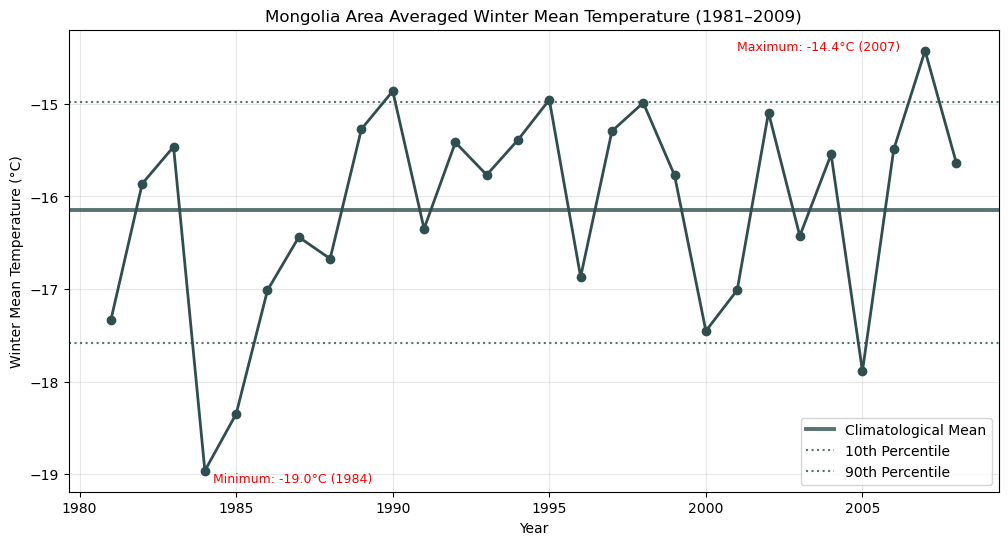

Climatological Mean: -16.139999389648438°C
Standard Deviation: 1.1299999952316284°C


In [3]:
winter = ds_era5.sel(time=ds_era5["time.month"].isin([11,12,1,2,3]))

winter["t2m_cel"] = winter["t2m"] - 273.15

winter_mean_temp = (winter["t2m_cel"].mean(dim=["latitude", "longitude"]).groupby("time.year").mean("time"))

dataframe_winter = (winter_mean_temp.compute().to_dataframe(name="winter_mean_temp_cel").reset_index())

clim_winter_mean = dataframe_winter["winter_mean_temp_cel"].mean()
std_temp = dataframe_winter["winter_mean_temp_cel"].std()

min_temp = dataframe_winter["winter_mean_temp_cel"].min()
min_tempyr = dataframe_winter.loc[dataframe_winter["winter_mean_temp_cel"]==min_temp, "year"].iloc[0]
max_temp = dataframe_winter["winter_mean_temp_cel"].max()
max_tempyr = dataframe_winter.loc[dataframe_winter["winter_mean_temp_cel"]==max_temp, "year"].iloc[0]

p10 = dataframe_winter["winter_mean_temp_cel"].quantile(0.10)
p90 = dataframe_winter["winter_mean_temp_cel"].quantile(0.90)

plt.figure(figsize=(12, 6))
plt.plot(
    dataframe_winter["year"],
    dataframe_winter["winter_mean_temp_cel"],
    marker="o",
    linewidth=2,
    color=bcolor
)
plt.axhline(
    clim_winter_mean,
    color=bcolor,
    alpha=0.8,
    linewidth=2.8,
    label="Climatological Mean"
)
plt.axhline(
    p10,
    color=bcolor,
    linestyle=":",
    alpha=0.8,
    label="10th Percentile"
)
plt.axhline(
    p90,
    color=bcolor,
    linestyle=":",
    alpha=0.8,
    label="90th Percentile"
)
plt.annotate(
    f'Minimum: {min_temp:.1f}°C ({min_tempyr})',
    xy=(min_tempyr, min_temp),
    xytext=(min_tempyr + 0.25, min_temp - 0.125),
    fontsize=9,
    color='red'
)
plt.annotate(
    f'Maximum: {max_temp:.1f}°C ({max_tempyr})',
    xy=(max_tempyr, max_temp),
    xytext=(max_tempyr - 6, max_temp),
    fontsize=9,
    color='red'
)
plt.xlabel("Year")
plt.ylabel("Winter Mean Temperature (°C)")
plt.title("Mongolia Area Averaged Winter Mean Temperature (1981–2009)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()
print(f"Climatological Mean: {round(clim_winter_mean, 2)}°C")
print(f"Standard Deviation: {round(std_temp, 2)}°C")

#### Interpretation

Winter mean temperatures show a relatively stable annual climate during the 1981-2008 baseline period, showing a consistent presence of temperature risks in the Mongolian winter. While most winters cluster around the climatological mean, several years stand out as significantly harsher, indicating periods of severely low temperatures well before the 2009-2010 dzud.

Mean winter temperatures do not solely capture dzud severity, as the extreme impacts are most often driven not by individually cold temperatures, but rather a persistent time of low temperatures with poor timing for subsistence farmers. Despite this, this metric provides essential context for exploring whether or not the 2009-2010 winter represented a departure from typical historical climate norms and sets up for more detailed analysis of the historical baseline period for a better insight. 

### Cold Spell Persistence 

Dzud impacts are often not caused by solely mean temperature alone, but rather by the persistence of extreme cold conditions. Prolonged cold spells have a serious impact on livestock and infrastructure, taking the already existing problems of an individual extreme cold day, increased caloric intake, potential injure, etc..., and insures that there are not days where these factors are less extreme. On top of this, the infrastructure costs are immense, with poorly designed buildings and metal infrastructure failing to ice and contracting metal, and water freezing consistently for days.

To demonstrate this aspect of winter severity, cold spell persistence is quantified as the duration of consecutive days which near surface temperature is below a certain threshold. This threshold is being defined as **-30°C**. In order to preserve spatial variability this is computed at the grid cell level. These grid cells are then spatially averaged to create a national scale indicator of cold spell persistence for each year.

**Why -30°C?**
- Widely referenced in dzud studies.
- Livestock energy requirements raise quickly.
- Frost injury risk rises.
- Access to pastures becomes even more difficult.

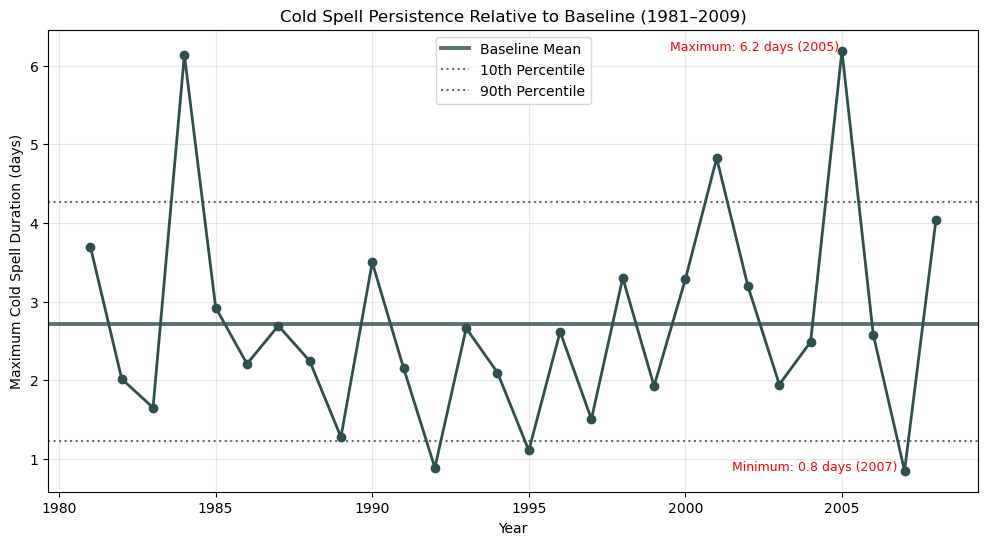

Climatological Mean: 3.0 days
Coefficient of Variance: 49.9%


In [4]:
cold_threshold = -30.0
t2m_winter = winter["t2m_cel"]

dataframe_cspell, mean_cspell = yearly_mean_max_persist(pdata=t2m_winter,threshold=cold_threshold,condition="le",metric_name="mean_max_cold_spell_days")

std_cspell= dataframe_cspell["mean_max_cold_spell_days"].std()
cv_spell = (std_cspell / mean_cspell) * 100

min_cspell = dataframe_cspell["mean_max_cold_spell_days"].min()
min_cspellyr = dataframe_cspell.loc[dataframe_cspell["mean_max_cold_spell_days"]==min_cspell, "year"].iloc[0]
max_cspell = dataframe_cspell["mean_max_cold_spell_days"].max()
max_cspellyr = dataframe_cspell.loc[dataframe_cspell["mean_max_cold_spell_days"]==max_cspell, "year"].iloc[0]

p10 = dataframe_cspell["mean_max_cold_spell_days"].quantile(0.10)
p90 = dataframe_cspell["mean_max_cold_spell_days"].quantile(0.90)

plt.figure(figsize=(12,6))
plt.plot(
    dataframe_cspell["year"],
    dataframe_cspell["mean_max_cold_spell_days"],
    marker="o",
    linewidth=2,
    color=bcolor
)
plt.axhline(
    mean_cspell,
    color=bcolor,
    linewidth=2.8,
    alpha=0.8,
    label="Baseline Mean"
)
plt.axhline(
    p10,
    color=bcolor,
    linestyle=":",
    alpha=0.8,
    label="10th Percentile"
)
plt.axhline(
    p90,
    color=bcolor,
    linestyle=":",
    alpha=0.8,
    label="90th Percentile"
)
plt.annotate(
    f'Minimum: {min_cspell:.1f} days ({min_cspellyr})',
    xy=(min_cspellyr, min_cspell),
    xytext=(min_cspellyr - 5.5, min_cspell),
    fontsize=9,
    color='red'
)
plt.annotate(
    f'Maximum: {max_cspell:.1f} days ({max_cspellyr})',
    xy=(max_cspellyr, max_cspell),
    xytext=(max_cspellyr - 5.5, max_cspell),
    fontsize=9,
    color='red'
)
plt.xlabel("Year")
plt.ylabel("Maximum Cold Spell Duration (days)")
plt.title("Cold Spell Persistence Relative to Baseline (1981–2009)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
print(f"Climatological Mean: {round(mean_cspell, 0)} days")
print(f"Coefficient of Variance: {round(cv_spell, 2)}%")

#### Interpretation

Cold spell persistence during the 1981-2008 period exhibits very high yearly variability, with nearly half of winters being above the baseline mean, and 3 being hazardously above it. The coefficient of variance is 50% showing that the year by year changes swing massively, with the minimum even being 0.8 cold spells in a year and 6.2 being the highest. These extended cold spells represent periods of increased baseline dzud risk, even without the anomalous snow conditions. Despite the overall substantial interannual variability the majority of the years in the historical baseline period are below the mean, giving a good background to explore how that changes with the 2009-2010 period.

Importantly, the distribution of cold spell durations reinforces that dzud like thermal stress is not solely associated with rare outliers but emerges from the upper tail of persistent characteristics. This shows the need to evaluate the winter of 2009-2010 in both magnitude and duration of the cold compared to the historic baseline, and that there is no sole factor in why dzud risk may appear.

### Snow Depth and Persistence

Persistent snow cover is a key factor in dzud, as deep or long lasting snow cover restricts livestock movement and access to food, amplifying the effects of extreme cold. Even in winters without exceptional snowfall total, prolonged periods of snow can significantly increase livestock mortality rates. On top of this, a lack of snowfall total is a potential risk, with it reducing the amount of moisture in both the ground and for human consumption later in the winter, creating a different but equally problematic risk.

To explore this component of winter severity, snow depth persistence is evaluated at a grid cell level. For each grid cell, the maximum number of consecutive days is calculated where the snow depth is greater than or equal to the threshold of **10.00cm (0.10m)**. These grid cells are then spatially averaged to produce a national indicator for snow persistence of each year.

**Why 10.00cm?**
- 10.00cm is the commonly cited value in dzud literature.
- This is the level at which grazing for animals becomes difficult.
- Potential foraged food becomes impossible to access consistently.
- Persistence of a depth is more important than overall depth, an invidual day of large snow depth may not effect livestock morality much.

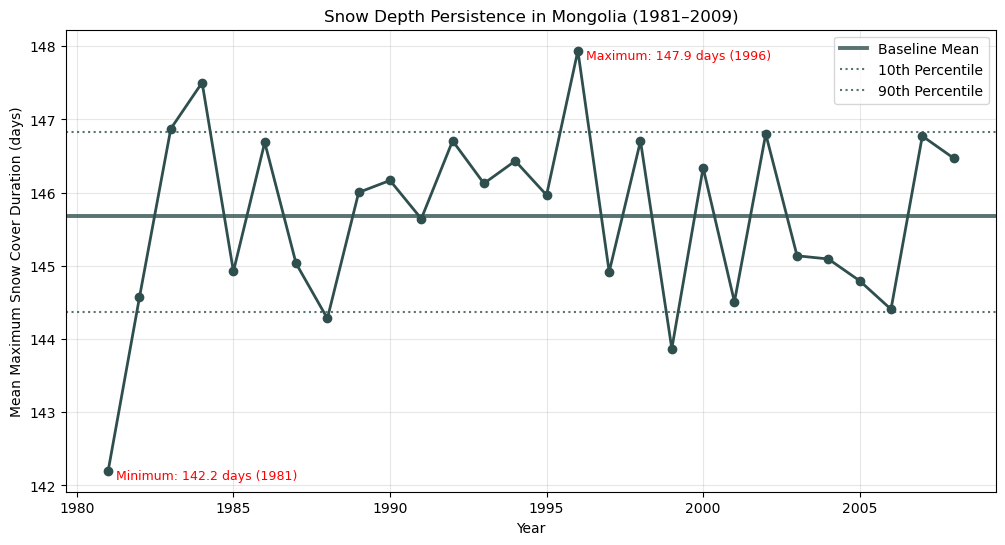

Climatological Mean: 146.0 days
Coefficient of Variance: 0.86%


In [5]:
snow_threshold = 0.10
snow_winter = ds_era5["sd"]

dataframe_snow, mean_snow = yearly_mean_max_persist(pdata=snow_winter,threshold=snow_threshold,condition="le",metric_name="mean_max_snow_spell_days")

std_snow = dataframe_snow["mean_max_snow_spell_days"].std()
cv_snow = (std_snow / mean_snow) * 100

min_snow = dataframe_snow["mean_max_snow_spell_days"].min()
min_snowyr = dataframe_snow.loc[dataframe_snow["mean_max_snow_spell_days"]==min_snow, "year"].iloc[0]
max_snow = dataframe_snow["mean_max_snow_spell_days"].max()
max_snowyr = dataframe_snow.loc[dataframe_snow["mean_max_snow_spell_days"]==max_snow, "year"].iloc[0]

p10 = dataframe_snow["mean_max_snow_spell_days"].quantile(0.10)
p90 = dataframe_snow["mean_max_snow_spell_days"].quantile(0.90)

plt.figure(figsize=(12,6))
plt.plot(
    dataframe_snow["year"],
    dataframe_snow["mean_max_snow_spell_days"],
    marker="o",
    linewidth=2,
    color=bcolor
)
plt.axhline(
    mean_snow,
    color=bcolor,
    linewidth=2.8,
    alpha=0.8,
    label="Baseline Mean"
)
plt.axhline(
    p10,
    color=bcolor,
    linestyle=":",
    alpha=0.8,
    label="10th Percentile"
)
plt.axhline(
    p90,
    color=bcolor,
    linestyle=":",
    alpha=0.8,
    label="90th Percentile"
)
plt.annotate(
    f'Minimum: {min_snow:.1f} days ({min_snowyr})',
    xy=(min_snowyr, min_snow),
    xytext=(min_snowyr + 0.25, min_snow - 0.125),
    fontsize=9,
    color='red'
)
plt.annotate(
    f'Maximum: {max_snow:.1f} days ({max_snowyr})',
    xy=(max_snowyr, max_snow),
    xytext=(max_snowyr + 0.25, max_snow - 0.125),
    fontsize=9,
    color='red'
)
plt.xlabel("Year")
plt.ylabel("Mean Maximum Snow Cover Duration (days)")
plt.title("Snow Depth Persistence in Mongolia (1981–2009)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()
print(f"Climatological Mean: {round(mean_snow, 0)} days")
print(f"Coefficient of Variance: {round(cv_snow, 2)}%")

#### Interpretation

Snow depth persistence during the historic baseline period shows a very grouped cyclical nature, especially from 1995-2003. Most winters are characterised by a ±2 days of persistence snow around the mean of 146.5, with a couple years in the baseline period being categorised as having much lower levels of persistent snow coverage but none falling outside of this range. This makes sense with the cv being 0.86%, showing little to no variability year by year.

These results highlights that snow is relatively consistently always a factor in Mongolia, with 97% of days on average in the winter having 10.00cm or more persistent snow coverage. This shows that while snow persistence has relatively little interannual variability at the national scale, this reflects the climatological reality of many regions of Mongolia consistently having snow coverage for the entirety of the winter. As a result of this, additional metrics focussing on spatial extent and severity of snow cover are required to more accurately explore hazardous dzud weather and its link with snow.

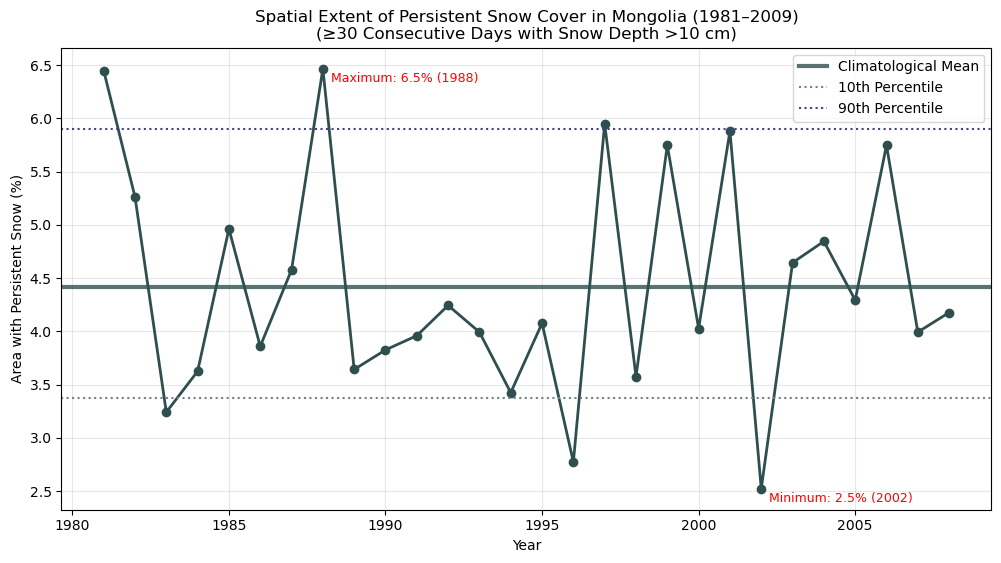

Climatological Mean: 4.42%
Coefficient of Variance: 23.77%


In [6]:
dataframe_snowex = yearly_persistence_extent(snow_winter,snow_threshold,min_days=30,condition="ge",metric_name="snow_persistence_ex")

mean_snowex = dataframe_snowex["snow_persistence_ex"].mean()
std_snowex = dataframe_snowex["snow_persistence_ex"].std()
cv_snowex = (std_snowex / mean_snowex) * 100
min_snowex = dataframe_snowex["snow_persistence_ex"].min()
min_snowexyr = dataframe_snowex.loc[dataframe_snowex["snow_persistence_ex"]==min_snowex, "year"].iloc[0]
max_snowex = dataframe_snowex["snow_persistence_ex"].max()
max_snowexyr = dataframe_snowex.loc[dataframe_snowex["snow_persistence_ex"]==max_snowex, "year"].iloc[0]

p10 = dataframe_snowex["snow_persistence_ex"].quantile(0.10)
p90 = dataframe_snowex["snow_persistence_ex"].quantile(0.90)

plt.figure(figsize=(12, 6))
plt.plot(
    dataframe_snowex["year"],
    dataframe_snowex["snow_persistence_ex"],
    marker="o",
    linewidth=2,
    color=bcolor
)
plt.axhline(
    mean_snowex,
    color=bcolor,
    linewidth=3,
    alpha=0.8,
    label="Climatological Mean"
)
plt.axhline(
    p10,
    color="slategrey",
    linestyle=":",
    label="10th Percentile"
)
plt.axhline(
    p90,
    color="darkslateblue",
    linestyle=":",
    label="90th Percentile"
)
plt.annotate(
    f'Minimum: {min_snowex:.1f}% ({min_snowexyr})',
    xy=(min_snowexyr, min_snowex),
    xytext=(min_snowexyr + 0.25, min_snowex - 0.125),
    fontsize=9,
    color='red'
)
plt.annotate(
    f'Maximum: {max_snowex:.1f}% ({max_snowexyr})',
    xy=(max_snowexyr, max_snowex),
    xytext=(max_snowexyr + 0.25, max_snowex - 0.125),
    fontsize=9,
    color='red'
)
plt.xlabel("Year")
plt.ylabel("Area with Persistent Snow (%)")
plt.title("Spatial Extent of Persistent Snow Cover in Mongolia (1981–2009)\n(≥30 Consecutive Days with Snow Depth >10 cm)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()
print(f"Climatological Mean: {round(mean_snowex, 2)}%")
print(f"Coefficient of Variance: {round(cv_snowex, 2)}%")

#### Interpretation

Building on the analysis of snow depth persistence duration, this graph presents a crucial metric: the spatial extent of persistent snow cover in Mongolia in the historic baseline period. While previous findings indicated that most winters have a tight range around the mean snow persistence duration of 146.5 days, covering 97% of days on average, this new metric addresses the need to understand how widespread the snow is. Over the historic baseline period, the climatological mean persistent snow extent was ~4.5% of Mongolia's total area. Completely opposing the low variability observed in snow duration, this spatial extent metric demonstrates considerable interannual fluctuation. Values ranged significantly from the minimum in 2002 of 2.5% and maximum in 1988 of 6.5%, with a high interannual variability across the entire period with a coefficient of variance of ~24%.

This pronounced variability in spatial coverage is important for understanding dzud risk. While consistent snow duration establishes snow as persistent factor in Mongolian winters, it is the extenet of this persistence that directly impacts the livestock mortality rates and the difficulties presented by dzud. Winters with a broad extent of persistent snow signify harsh restriction to pasture access across large parts of the country, amplifying the other variables and risks of dzud.

This there highlights that spatial variability of persistent snow cover across Mongolia is essential for evaluating the severity of the 2009-2010 dzud winter, an event recognised for its serious socio economic and environmental impacts in Mongolia.

### Interannual Variability

To assess the severity of the 2009-2010 winter in comparison to the historical baseline, it is necessary to understand how Mongolia's winter climate typical varies yearly. Dzud does not arise from isolated extremes, but rather from the combination and complementing of persistent cold conditions and snow cover over the entire winter season. As such evaluating interannual variability provides critical context for showing exceptional winters from those that fall within the range of natural variability.

In this section the historical baseline period is used to characterise the distribution of the key winter indicators already analysed in this historic section. These distributions represent the range of winter conditions experienced in Mongolia prior to the 2009-2010 event of analysis and is the reference against which the dzud is analysed.

Rather than focussing on time series behaviour, this analysis emphasises distribution metrics, allowing the 2009-2010 winter to be placed within the historical range of observed variability. This approach is similar to the methodology applied in the Chad drought analysis, enabling direct comparison across distinct regions in the subsequent analysis.

**Indicators are**:

- Winter mean temperature
- Persistence of extreme cold spells (≤ −30 °C)
- Spatial extent of persistent snow cover

Together, these metrics capture the thermal severity, temporal persistence, and spatial scale of winter hazards associated with dzud.

In [7]:
event_winter_mean_temp = (winter_event["t2m_cel"].mean(dim=["latitude", "longitude"]).mean(dim="time").load().item())

dataframe_cevent, _ = yearly_mean_max_persist(pdata=winter_event["t2m_cel"],threshold=-30.0,condition="le",metric_name="mean_max_cold_spell_days")

event_cspell = dataframe_cevent["mean_max_cold_spell_days"].iloc[0]

event_snow_ext = yearly_persistence_extent(pdata=winter_event["sd"],threshold=0.10,min_days=30,condition="ge",metric_name="snow_persistence_ex")
event_snow_extent = event_snow_ext["snow_persistence_ex"].iloc[0]

bins_dist = int(np.ceil(np.log2(28) + 1))

#### Distribution of winter mean temperature

Winter mean temperature provides an image of temperature severity during the winter in Mongolia. While dzud impacts are generally more effected by persistent cold rather than individual cold days, the seasonal mean still provides important context into the overall harshness of the winter severity and discovering winters which are especially anomalous on an individually cold scale.

The distribution of area averaged mean winter temperature across Mongolia is constructed with the 1981-2008 baseline period. The winter of 2009-2010 is then applied onto the distribution to assess where in the historic baseline the analysed winter falls as an anomalous period of extreme cold.

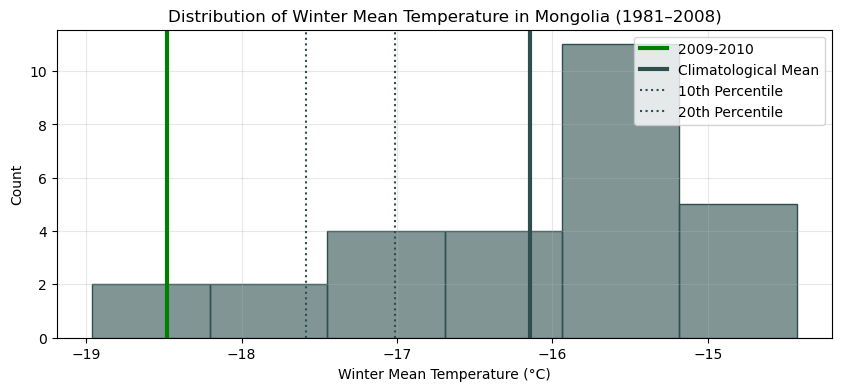

2009-2010 Winter: -18.48°C
2009–2010 winter mean temperature percentile: 3.6%
Climatological Mean: -16.14°C
10th Percentile: -17.58°C
20th Percentile: -17.01°C


In [8]:
baseline_temp = dataframe_winter["winter_mean_temp_cel"]

p10 = baseline_temp.quantile(0.10)
p20 = baseline_temp.quantile(0.20)

plt.figure(figsize=(10,4))
sns.histplot(
    baseline_temp,
    bins=bins_dist,
    color=bcolor,
    alpha=0.6,
    edgecolor=bcolor
)
plt.axvline(
    event_winter_mean_temp,
    color="green",
    linewidth=3,
    label="2009-2010"
)
plt.axvline(
    clim_winter_mean,
    color=bcolor,
    linewidth=3,
    label="Climatological Mean"
)
plt.axvline(
    p10,
    color=bcolor,
    linestyle=":",
    label="10th Percentile"
)
plt.axvline(
    p20,
    color=bcolor,
    linestyle=":",
    label="20th Percentile"
)
plt.xlabel("Winter Mean Temperature (°C)")
plt.title("Distribution of Winter Mean Temperature in Mongolia (1981–2008)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

temp_percentile = (baseline_temp < event_winter_mean_temp).mean() * 100
print(f"2009-2010 Winter: {round(event_winter_mean_temp, 2)}°C")
print(f"2009–2010 winter mean temperature percentile: {temp_percentile:.1f}%")
print(f"Climatological Mean: {round(clim_winter_mean.astype(float), 2)}°C")
print(f"10th Percentile: {round(p10, 2)}°C")
print(f"20th Percentile: {round(p20, 2)}°C")

**Interpretation**

The historical distribution of winter mean temperature demonstrates moderate interannual variability, reflecting the harsh but also diversely variable climate of Mongolia. The vast majority of winters are around or above the climatological mean, with progressively fewer and fewer years going towards the colder tail of the distribution.

When placed alongside the distribution, the winter of 2009-2010 falls as one of the on average coldest winters in the analysed dataset and modern mongolian history. It is at the ~4th percentile, highlighting how massively cold of a winter it was. This shows the importance of how alongside other drivers in dzud risk, that temperature plays a significant role. 

#### Distribution of Cold Spell Persistence

Dzud is strongly influenced by the persistence of extreme cold rather than by the mean temperature alone. Prolonged cold spells increase livestock mortality by sustaining higher caloric needs, limiting mobility, and exacerbating frost injuries, particularly when access to pastures is already limited.

To capture this dimension of winter severity, cold spell persistence is defined as the maximum number of consecutive days which the surface air temperature remains below -30 °C. This metric is computed in grid cells and spatially averaged to produce a nationally averaged indicator for every winter.

The distribution of cold spell persistence during the 1981-2008 baseline period provides a backdrop for assessing whether the length of extreme cold in the analysed period winter was anomalous in a historic context.

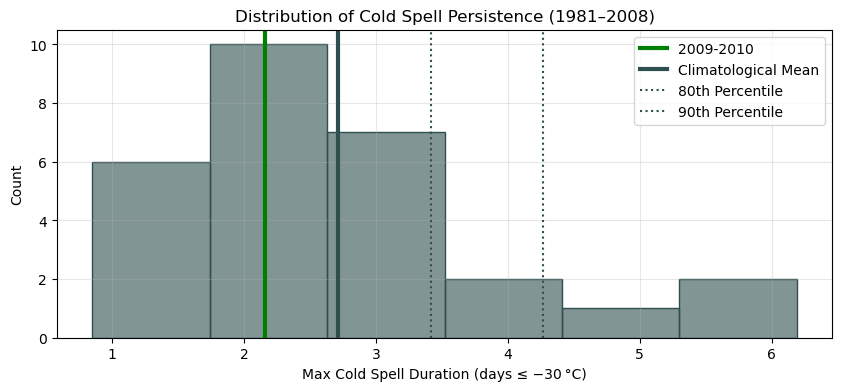

2009-2010 Winter: 2.2 days
Climatological Mean: 2.7 days
80th Percentile: 3.4 days
90th Percentile: 4.3 days


In [9]:
baseline_cold = dataframe_cspell["mean_max_cold_spell_days"]

p80 = baseline_cold.quantile(0.80)
p90 = baseline_cold.quantile(0.90)

plt.figure(figsize=(10,4))
sns.histplot(
    baseline_cold,
    bins=bins_dist,
    color=bcolor,
    alpha=0.6,
    edgecolor=bcolor
)
plt.axvline(
    event_cspell,
    color="green",
    linewidth=3,
    label="2009-2010"
)
plt.axvline(
    mean_cspell,
    color=bcolor,
    linewidth=3,
    label="Climatological Mean"
)
plt.axvline(
    p80,
    color=bcolor,
    linestyle=":",
    label="80th Percentile"
)
plt.axvline(
    p90,
    color=bcolor,
    linestyle=":",
    label="90th Percentile"
)
plt.xlabel("Max Cold Spell Duration (days ≤ −30 °C)")
plt.title("Distribution of Cold Spell Persistence (1981–2008)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
print(f"2009-2010 Winter: {round(event_cspell, 1)} days")
print(f"Climatological Mean: {round(mean_cspell, 1)} days")
print(f"80th Percentile: {round(p80, 1)} days")
print(f"90th Percentile: {round(p90, 1)} days")

**Interpretation**

The distribution of cold spell persistence during the 1981–2008 baseline indicates that multi day periods with temperatures below −30 °C are a common feature of Mongolian winters. When placed within this distribution, the 2009–2010 winter falls close to the climatological mean, suggesting that extreme cold persistence alone was not exceptional at the national scale.

This result highlights that dzud severity does not arise from cold persistence in isolation, but rather from its interaction with widespread snow cover and preexisting summer pasture deficits.

#### Distribution of Spatial Extent of Persistent Snow Cover

Snow cover is a major part of dzud, as persistent and widespread snow limits livestock access to pastures and restricts access to areas. While snow is a climatological feature of Mongolian winters, the spatial extent of long lasting snow cover varies substantially between years and is a key role in determining the severity of winters.

In this analysis, snow persistence is evaluated in terms of the amount of Mongolia experiencing at least 30 consecutive days with a snow depth greater than 10.00 cm. This metric shows not only the duration of snow at individual locations but also its spatial reach across the entire country.

The historic distribution of this spatial persistence during 1981-2008 provides greater context into how often winters are characterised by long lasting snow cover.

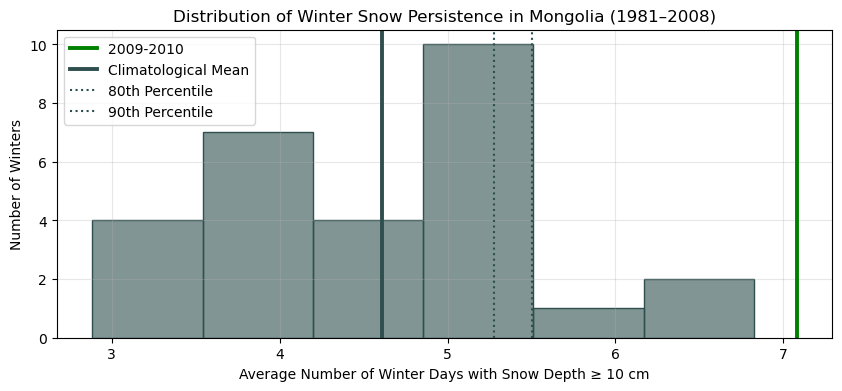

2009-2010 Winter: 7.1 days
Climatological Mean: 4.6 days
80th Percentile: 5.3 days
90th Percentile: 5.5 days


In [10]:
n_days_event = winter_event.sizes["time"]
snow_mask = (winter["sd"] >= 0.10)

snow_days_event = ((winter_event["sd"] >= 0.10).mean(dim="time").mean(dim=["latitude", "longitude"])*n_days_event).compute().item()

winter_days = snow_mask.groupby("time.year").count(dim="time").mean(dim=["latitude", "longitude"])
snow_fraction_baseline = (snow_mask.groupby("time.year").mean(dim="time").mean(dim=["latitude", "longitude"]))
snow_days_baseline = snow_fraction_baseline * winter_days

q = snow_days_baseline.quantile([0.80, 0.90])
stats = xr.Dataset({
    "mean": snow_days_baseline.mean(),
    "p80": q.sel(quantile=0.80).reset_coords("quantile", drop=True),
    "p90": q.sel(quantile=0.90).reset_coords("quantile", drop=True),
}).compute()


mean_snow_days = stats["mean"].item()
p80 = stats["p80"].item()
p90 = stats["p90"].item()


plt.figure(figsize=(10,4))
sns.histplot(
    snow_days_baseline.values,
    bins=bins_dist,
    color=bcolor,
    alpha=0.6,
    edgecolor=bcolor
)
plt.axvline(
    snow_days_event,
    color="green",
    linewidth=2.8,
    label="2009-2010"
)
plt.axvline(
    mean_snow_days,
    color=bcolor,
    linewidth=2.8,
    label="Climatological Mean"
)
plt.axvline(
    p80,
    color=bcolor,
    linestyle=":",
    label="80th Percentile"
)
plt.axvline(
    p90,
    color=bcolor,
    linestyle=":",
    label="90th Percentile"
)
plt.xlabel("Average Number of Winter Days with Snow Depth ≥ 10 cm")
plt.ylabel("Number of Winters")
plt.title("Distribution of Winter Snow Persistence in Mongolia (1981–2008)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
print(f"2009-2010 Winter: {round(snow_days_event, 1)} days")
print(f"Climatological Mean: {round(mean_snow_days, 1)} days")
print(f"80th Percentile: {round(p80, 1)} days")
print(f"90th Percentile: {round(p90, 1)} days")

**Interpretation**

The baseline distribution of the average number of winter days with snow depth greater than 10.00cm shows that most Mongolian winters experience some form of persistence snow cover for a limited number of days when averaged across the country, with the vast majority of winters clustering well below the upper tail. Winters exceeding the 90th percentile make up a very small portion of the baseline, representing years that snow cover is persistent and widespread.

When placed in the historic baseline period, the winter of 2009-2010 stands out as incredibly anomalous. The dzud winter lies well past the 90th percentile of the historic distribution, and past any recorded data in the ~30 year timeframe. This indicates that the snow cover during this period was both incredibly persistent and spatially extensive. This result confirms that snow cover played a significant role in amplifying dzud risk by severely limiting livestock access to pasture across large parts of Mongolia.

#### Overall Interpretation

Taken alongside with the temperature based analyses, this snow persistence model provides a clear picture of the climatic factors involved with the 2009-2010 dzud. While winter mean temperature ranks among the coldest in the historical period, persistence cold spell metrics categorised by runs of extreme cold do not indicated anomalously long cold spells relative to the baseline. The highlights that dzud severity in 2009-2010 was not driven by cold outbreaks solely.

Instead of this, the defining feature of the dzud winter in 2009-2010 emerges from the combined interaction of a sustained cold climate with exceptionally persistent and widespread snow cover. Even in the absence of very large cold spell durations, prolonged snow cover severely restricted grazing access, increased caloric requirements of livestock, and increased vulnerability to otherwise normal cold extremes.

### Summer Historical Precipitation Baseline

Mongolia's pastoral systems are highly sensitive to summer precipitation as it controls pasture growth, foraging availability, and the condition of livestock prior to the winter. While dzud manifests in the winter, the severity of a dzud and the reasons for the high livestock mortality originate in the preconditioning of the pastures in the summer. The main problem being periods of low average rainfall or drought during the summer causing low biomass accumulation thus leaving livestock already primed for the subsequent winter stressors.

To create the climatological context for the 2009-2010 dzud, this section examines historical precipitation variability during the summer seasons of 1981-2008. Summer here is defined as June to October, being the primary time frame for pasture growth in much of Mongolia. Three figures are used to characterise the summer rainfall variability during the historic baseline period,
- **Summer Mean Precipitation**: Describes typical summer rainfall conditions.  
- **Summer Rainfall Distribution & Percentiles**: Compares the 2009 summer to the percentiles and distribution of the historic baseline.  
- **Frequency of dry summers**: Assesses how frequent rainfall deficits are in the summer of Mongolia, and the relevance to dzud conditioning.

Together these figures determine what is considered a normal summer vs an anomalous summer in relation to dzud risk in Mongolia, setting a baseline for the further analysis of the 2009 summer.

In [11]:
smonths = [6, 7, 8, 9, 10]
lat_min, lat_max = 41.0, 52.0
long_min, long_max = 87.0, 120.0

ds_summer_2009 = xr.open_dataset(
    chirps_primary_dir / "chirps-v2.0.2009.days_p25.nc"
)

summer_baseline = ds_chirps.sel(
    latitude=slice(lat_min, lat_max),
    longitude=slice(long_min, long_max),
    time=ds_chirps["time.month"].isin(smonths)
)

summer_2009 = ds_summer_2009.sel(
    latitude=slice(lat_min, lat_max),
    longitude=slice(long_min, long_max),
    time=ds_summer_2009["time.month"].isin(smonths)
)

#### Summer Mean Precipitation

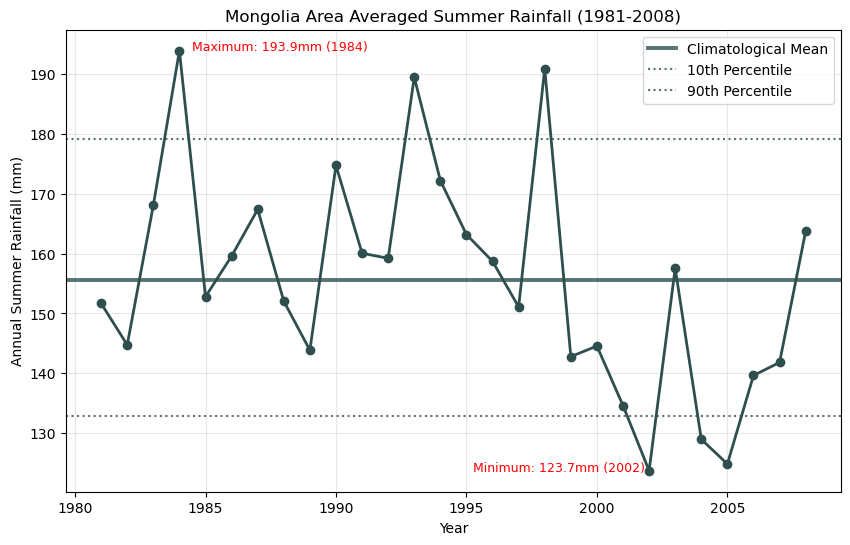

Climatological Mean: 155.56mm
Coefficient of Variation: 11.83%


In [12]:
bsummer_total = (summer_baseline["precip"].mean(dim=["latitude","longitude"]).groupby("time.year").sum("time"))

dataframe_bsummer = bsummer_total.compute().to_dataframe(name="summer_rainfall_mm").reset_index()

bsum_mean = dataframe_bsummer["summer_rainfall_mm"].mean()
bsum_std = dataframe_bsummer["summer_rainfall_mm"].std()
bsum_cv = bsum_std / bsum_mean
bsum_cv = round((bsum_cv.astype(float) * 100), 2)
bsum_mean = round((bsum_mean.astype(float)), 2)

min_rain = dataframe_bsummer["summer_rainfall_mm"].min()
min_rainyr = dataframe_bsummer.loc[dataframe_bsummer["summer_rainfall_mm"]==min_rain, "year"].iloc[0]
max_rain = dataframe_bsummer["summer_rainfall_mm"].max()
max_rainyr = dataframe_bsummer.loc[dataframe_bsummer["summer_rainfall_mm"]==max_rain, "year"].iloc[0]

p10 = dataframe_bsummer["summer_rainfall_mm"].quantile(0.10)
p90 = dataframe_bsummer["summer_rainfall_mm"].quantile(0.90)

plt.figure(figsize=(10,6))
plt.plot(
    dataframe_bsummer["year"],
    dataframe_bsummer["summer_rainfall_mm"],
    marker="o",
    color=bcolor,
    linewidth=2
)
plt.axhline(
    bsum_mean,
    color=bcolor,
    linewidth=2.8,
    alpha=0.8,
    label="Climatological Mean"
)
plt.axhline(
    p10,
    color=bcolor,
    linestyle=":",
    alpha=0.8,
    label="10th Percentile"
)
plt.axhline(
    p90,
    color=bcolor,
    linestyle=":",
    alpha=0.8,
    label="90th Percentile"
)
plt.annotate(
    f'Minimum: {min_rain:.1f}mm ({min_rainyr})',
    xy=(min_rainyr, min_rain),
    xytext=(min_rainyr - 6.75, min_rain - 0.175),
    fontsize=9,
    color='red'
)
plt.annotate(
    f'Maximum: {max_rain:.1f}mm ({max_rainyr})',
    xy=(max_rainyr, max_rain),
    xytext=(max_rainyr + 0.5, max_rain),
    fontsize=9,
    color='red'
)
plt.xlabel("Year")
plt.ylabel("Annual Summer Rainfall (mm)")
plt.title("Mongolia Area Averaged Summer Rainfall (1981-2008)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()
print(f"Climatological Mean: {bsum_mean}mm")
print(f"Coefficient of Variation: {bsum_cv}%")

**Interpretation**

The area averaged summer precipitation time series shows a moderate amount of interannual variability during the historic baseline period, with a CV of 12%. There is a significant amount of clustering around the mean with a couple of large spikes with significantly more rainfall in the summer season or in the case of many years 2000 onwards well below the mean. This reflects the inherently variable nature of Mongolia's summer climate.

This variability shows that pasture conditions and quality can enter winter significantly differently year by year, even in the absence of long term trends. As such, summer rainfall anomalies present an important preconditioning factor for dzud risk, as livestock entering a harsh winter following a dry summer are more susceptible to winter related stresses.

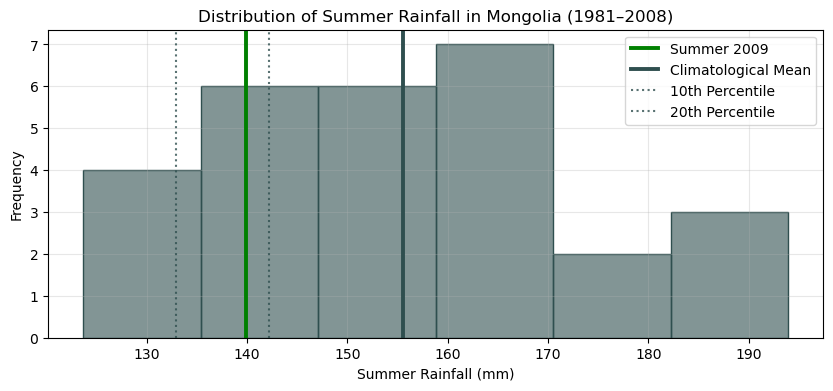

2009 Summer Rainfall: 139.91mm
2009 Summer Percentile: 18.0%
Climatological Mean: 155.56mm
10th Percentile: 5.28mm
90th Percentile: 179.16mm


In [13]:
summer_2009_total = summer_2009["precip"].mean(dim=["latitude", "longitude"]).sum("time").compute().item()
baseline_rain = dataframe_bsummer["summer_rainfall_mm"]
s2009_percentile = (baseline_rain < summer_2009_total).mean() * 100

p20 = dataframe_bsummer["summer_rainfall_mm"].quantile(0.20)
p10 = dataframe_bsummer["summer_rainfall_mm"].quantile(0.10)

bins_sumprecip = int(np.ceil(np.log2(len(dataframe_bsummer)) + 1))

plt.figure(figsize=(10,4))
sns.histplot(
    dataframe_bsummer["summer_rainfall_mm"],
    bins=bins_sumprecip,
    color=bcolor,
    alpha=0.6,
    edgecolor=bcolor
)
plt.axvline(
    summer_2009_total,
    color="green",
    linewidth=2.8,
    label="Summer 2009"
)
plt.axvline(
    bsum_mean,
    color=bcolor,
    linewidth=2.8,
    label="Climatological Mean"
)
plt.axvline(
    p10,
    color=bcolor,
    linestyle=":",
    alpha=0.8,
    label="10th Percentile"
)
plt.axvline(
    p20,
    color=bcolor,
    linestyle=":",
    alpha=0.8,
    label="20th Percentile"
)
plt.xlabel("Summer Rainfall (mm)")
plt.ylabel("Frequency")
plt.title("Distribution of Summer Rainfall in Mongolia (1981–2008)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()
print(f"2009 Summer Rainfall: {round(summer_2009_total, 2)}mm")
print(f"2009 Summer Percentile: {round(s2009_percentile, 0)}%")
print(f"Climatological Mean: {round(bsum_mean, 2)}mm")
print(f"10th Percentile: {round(p80, 2)}mm")
print(f"90th Percentile: {round(p90, 2)}mm")

**Interpretation**

The historical distribution of summer rainfall reveals a broad range of conditions experienced during the baseline period, with most summers falling within a central band of variability and progressively fewer years occupying the lower and upper tail of the distribution. Percentile thresholds provide a useful reference for identifying summers characterized by anomalously low rainfall relative to historical norms.

Overlaying the summer of 2009 onto this distribution allows its position within the historical context to be assessed objectively. As it highlights here, the summer of 2009 would be considered moderately dry at the 18th percentile, however as a preconditioning variable this alone can amplify the effects of the historical snow persistence and very low temperatures.

In [14]:
dataframe_bsummer["dry_10"] = dataframe_bsummer["summer_rainfall_mm"] <= p10
dataframe_bsummer["dry_20"] = dataframe_bsummer["summer_rainfall_mm"] <= p20

dcount_10 = dataframe_bsummer["dry_10"].sum()
dcount_20 = dataframe_bsummer["dry_20"].sum()

dcount10_pct = dcount_10 / len(dataframe_bsummer) * 100
dcount20_pct = dcount_20 / len(dataframe_bsummer) * 100

dry_years = dataframe_bsummer.loc[
    dataframe_bsummer["dry_20"],
    ["year", "summer_rainfall_mm"]
]
print(f"Percentage of Dry Years: {round(dcount20_pct, 2)}%")
print(f"Percentage of Potential Drought Years: {round(dcount10_pct, 2)}%")
print("List of Dry Years:")
dry_years

Percentage of Dry Years: 21.43%
Percentage of Potential Drought Years: 10.71%
List of Dry Years:


,year,summer_rainfall_mm
20,2001,134.587173
21,2002,123.692123
23,2004,128.947342
24,2005,124.821915
25,2006,139.622818
26,2007,141.797760


**Interpretation**

During the 1981-2008 baseline period, 21.5% of summers can be classified as dry summers, while a smaller number fall belowthe 10th percentile and represent the more severe rainfall deficits, potential drought. These dry summers are all consectutive, from the years of 2001-2007, and clearly show that there has been a trending direction of low rainfall up to the summer of 2009. As such the summer of 2009 and therefore the winter of 2009-100 may have been affected by already pre existing low moisture in the ground, exacerbating the dryness of the summer of 2009. 

The existence of this recent trend of dry summers suggests that there is an underlying preconditioning with rainfall for the 2009-2010 dzud, and that further insight may reveal how significant the preconditioning factor was in the dzud.

## Summer 2009 Preconditioning Analysis

The historical baseline and distribution shows that the 2009 summer was lower in the distribution for a summers rainfal, but does not explore how climatic stress manifested during the summer. Dzud risk is strongly influenced by the spatial extent, persistence, and timing of rainfall deficits during the summer which directly affect pasture growth and livestock healthiness heading into the winter.

This section examines summer 2009 precipitation patterns in detail, focusing on spatial heterogeneity and the temporal structure of rainfall during the growing season. Rather than treating summer rainfall as a single aggregated value, the analysis explores where rainfall deficits were concentrated, how persistent dry conditions were, and whether rainfall was distributed in a manner conducive to sustained pasture growth. To explore this, the categories for the preconditioning analysis are:  
- National Severity of Summer 2009  
- Spatial Pattern of Summer 2009 Rainfall  
- Persistence of Dry Conditions
- Spatial SPI of Summer 2009 Rainfall  
- Timing of Summer Rainfall    

These categories will successfully capture the anomalous nature of the 2009 summer, where it occurred and how badly it affected pasture land as well as the length of this damage, and also if the risk of low rainfall was worse in the early or end of the season. 

Summer 2009 z-score: -0.85


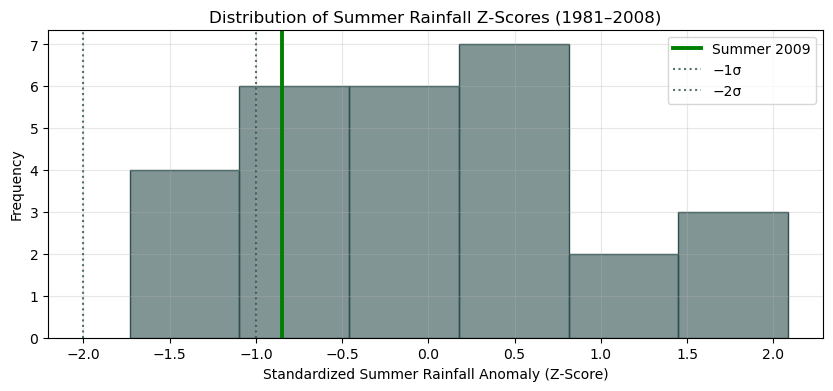

In [15]:
zscore_summer_2009 = (summer_2009_total - bsum_mean) / bsum_std
print(f"Summer 2009 z-score: {zscore_summer_2009:.2f}")

dataframe_bsummer["z_score"] = (
    (dataframe_bsummer["summer_rainfall_mm"] - bsum_mean) / bsum_std
)

plt.figure(figsize=(10, 4))
sns.histplot(
    dataframe_bsummer["z_score"],
    bins=bins_sumprecip,
    color=bcolor,
    alpha=0.6,
    edgecolor=bcolor
)
plt.axvline(
    zscore_summer_2009,
    color="green",
    linewidth=2.8,
    label="Summer 2009"
)
plt.axvline(
    -1, 
    color=bcolor, 
    linestyle=":",
    alpha=0.8,
    label="−1σ"
)
plt.axvline(
    -2, 
    color=bcolor, 
    linestyle=":",
    alpha=0.8,
    label="−2σ"
)
plt.xlabel("Standardized Summer Rainfall Anomaly (Z‑Score)")
plt.ylabel("Frequency")
plt.title("Distribution of Summer Rainfall Z‑Scores (1981–2008)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### Interpretation

The z-score indicates that summer 2009 was moderately dry, but not clearly anomalous when assessed using regionally averaged total rainfall. This suggests that preconditioning of the 2009–2010 dzud cannot be explained by rainfall anomaly magnitude alone, and instead requires consideration of the spatial and temporal distribution of precipitation and its impacts on pasture productivity.

To provide a more standardized assessment of drought, I calculate the Standardized Precipitation Index (SPI) for July–September 2009. SPI expresses precipitation anomalies in units of standard deviation relative to a historical baseline, allowing direct comparison across years and regions.

To calculate SPI, I first aggregate CHIRPS monthly precipitation data for the three summer months (July–September) across the study area. Using historical data for the same months (1981–2020) as a reference, I fit a gamma distribution to the long-term precipitation record and then transform the probability of the observed precipitation to a standard normal distribution. The resulting SPI values indicate whether the summer was unusually dry (negative SPI) or wet (positive SPI), with larger negative values corresponding to more severe drought conditions.

This approach complements the z-score by providing a standardized measure of drought severity that can be further analyzed spatially and temporally to understand how summer 2009 may have preconditioned the subsequent dzud.

### SPI for July-September

SPI measures accumulated rainfall over the core pasture growth period, standardized relative to historical variability. For Mongolia, this is ideal because:
- July–September captures peak biomass accumulation
- Livestock condition is highly sensitive to deficits during this window
- SPI removes bias from absolute rainfall magnitude

**SPI interpretation**:
- SPI = 0 → normal
- SPI < −1 → moderate drought
- SPI < −1.5 → severe drought
- SPI < −2 → extreme drought


July-September Rainfall 2009: 102.01mm
National SPI 3 2009: -0.8


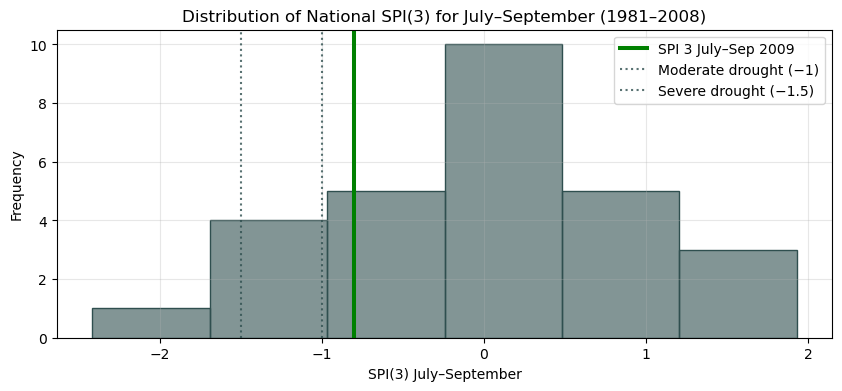

In [16]:
spi_months = [7, 8, 9]
bins_spi = int(np.ceil(np.log2(28) + 1))

spi_baseline = (summer_baseline["precip"].sel(time=summer_baseline["time.month"].isin(spi_months)).groupby("time.year").sum("time").mean(dim=["latitude", "longitude"]).compute())

spi_years = spi_baseline["year"].values
spi_values = spi_baseline.values

spi_2009 = (summer_2009["precip"].sel(time=summer_2009["time.month"].isin(spi_months)).mean(dim=["latitude", "longitude"]).sum("time").compute().item())
print(f"July-September Rainfall 2009: {round(spi_2009, 2)}mm")

shape, loc, scale = gamma.fit(spi_values, floc=0)
cdf_baseline = gamma.cdf(spi_values, shape, loc=loc, scale=scale)
spi_baseline_vals = stats_norm.ppf(cdf_baseline)

cdf_2009 = gamma.cdf(spi_2009, shape, loc=loc, scale=scale)
spi_2009_val = stats_norm.ppf(cdf_2009)
print(f"National SPI 3 2009: {round(spi_2009_val, 2)}")

plt.figure(figsize=(10,4))
sns.histplot(
    spi_baseline_vals,
    bins=bins_spi,
    color=bcolor,
    alpha=0.6,
    edgecolor=bcolor
)
plt.axvline(
    spi_2009_val,
    color="green",
    linewidth=2.9,
    label="SPI 3 July–Sep 2009"
)
plt.axvline(
    -1,
    color=bcolor,
    alpha=0.8,
    linestyle=":",
    label="Moderate drought (−1)"
)
plt.axvline(
    -1.5,
    color=bcolor,
    alpha=0.8,
    linestyle=":",
    label="Severe drought (−1.5)"
)
plt.xlabel("SPI(3) July–September")
plt.ylabel("Frequency")
plt.title("Distribution of National SPI(3) for July–September (1981–2008)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

#### Interpretation

The national SPI 3 for 2009 indicates near moderate drought conditions, further highlighting that national averaging of rainfall totals does not fully explore the preconditioning involved in the 2009-2010 dzud. This demonstrates that despite rainfall totals and SPI values being relatively normal compared to the historical baseline, there is clearly something more underlying as to why the 2009-2010 dzud was so disastrous. What this therefore concludes is that greater emphasis on temporal and more importantly spatial analysis of the 2009 summer is required, in order to fully capture what it was with the summer of 2009 causing poor pasture conditions and lack of biomass accumulation.

## Spatial Pattern of Summer 2009 Rainfall

National metrics can obscure important regional variability in precipitation, particularly in a country as large and climatically heterogeneous as Mongolia. Pastoral impacts depend not only on how much rain falls on average, but also where rainfall deficits occur, especially in regions supporting high livestock densities.

This section examines the spatial distribution of summer 2009 rainfall anomalies relative to the 1981–2008 climatology. By mapping rainfall departures at the grid cell level, this analysis identifies regions that experienced anomalously dry conditions during the growing season and assesses whether rainfall deficits were localised or widespread across Mongolia.

**Note**:
Data coverage does not extend into far northern Mongolia, and as such is blank in mapping

Grazing Area Mean Change: -14.41%
Grazing Area Median Change: -18.81%


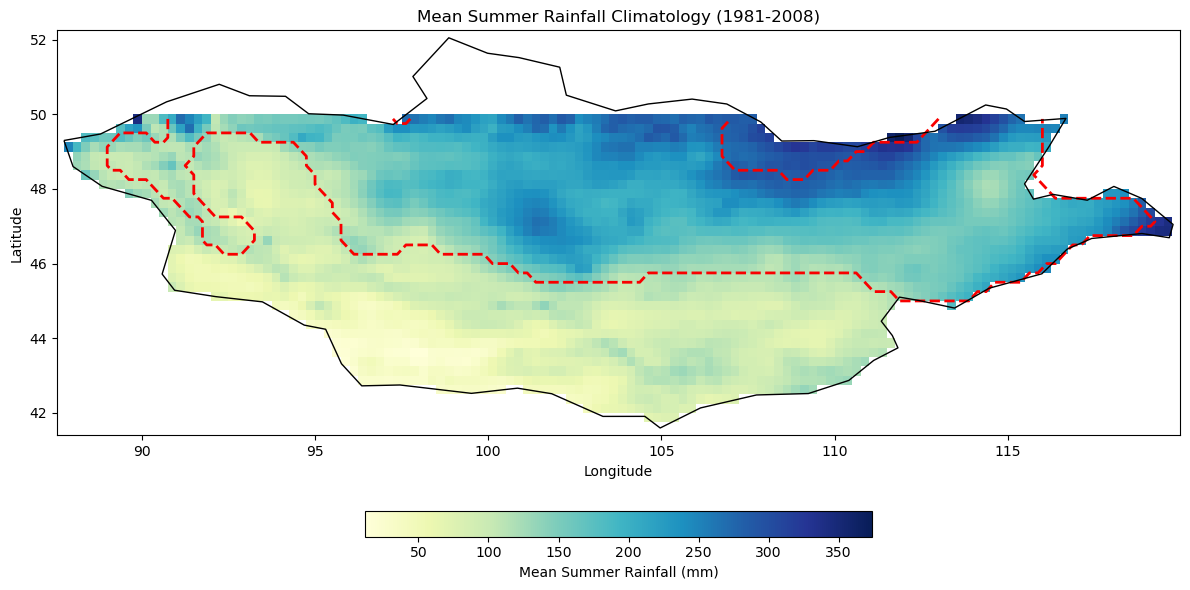

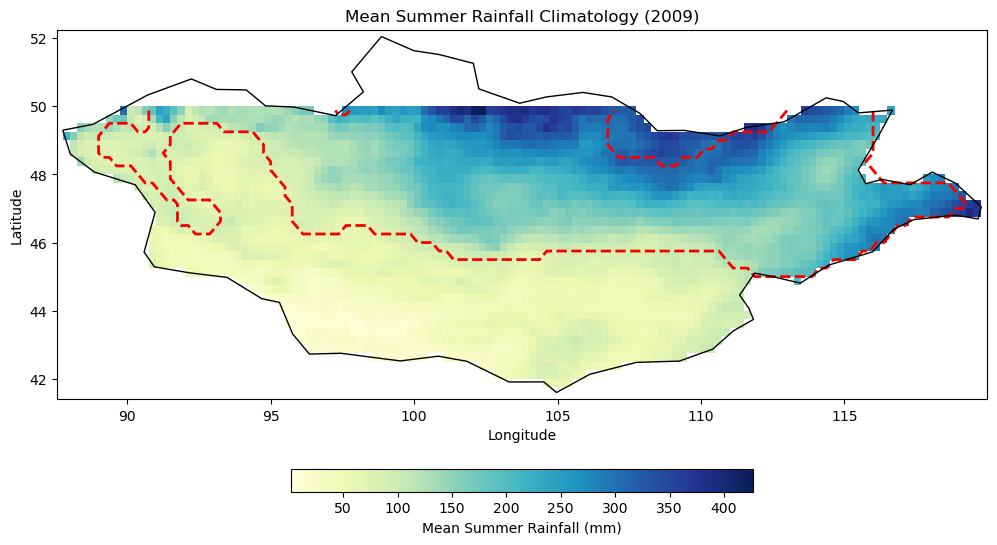

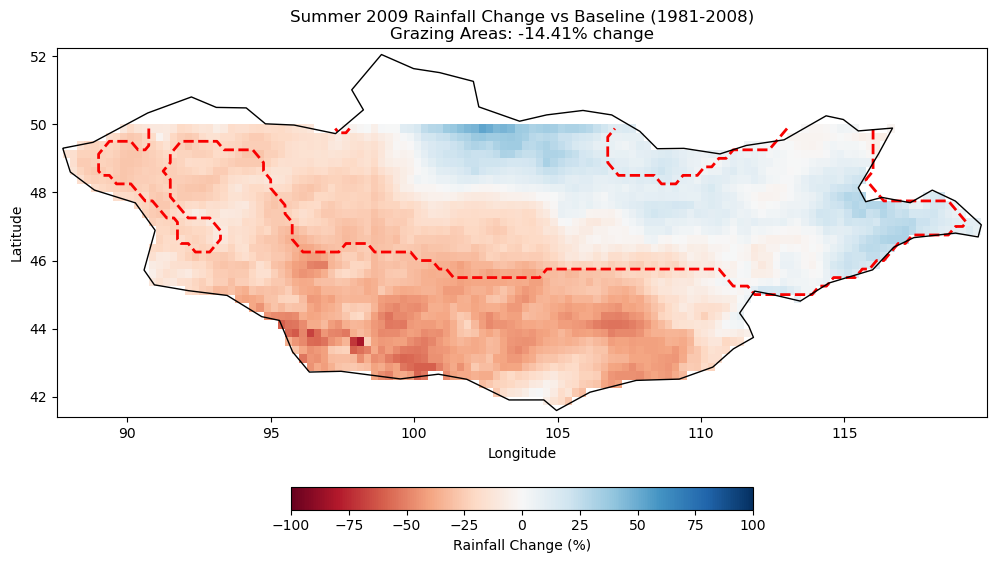

In [23]:
baseline_clim = (summer_baseline["precip"].resample(time="1YE").sum().mean("time").rio.write_crs("EPSG:4326", inplace=False))

baseline_clim = baseline_clim.compute()
baseline_mongolia = baseline_clim.rio.clip(
    mongolia_shape.geometry,
    mongolia_shape.crs,
    drop=True
)

summer_2009_total_map = (summer_2009["precip"].sum("time").rio.write_crs("EPSG:4326", inplace=False))

summer_2009_total_map = summer_2009_total_map.compute()
summer_2009_clip = summer_2009_total_map.rio.clip(
    mongolia_shape.geometry,
    mongolia_shape.crs,
    drop=True
)

landcover_resample = landcover.rio.reproject_match(
    baseline_mongolia,
    resampling=Resampling.nearest
)

grazing_mask = landcover_resample.isin([20, 30])
smoothed_mask = gaussian_filter(grazing_mask.values.astype(float), sigma=2) > 0.5
grazing_mask_smooth = grazing_mask.copy(data=smoothed_mask.astype(float))

pct_change = ((summer_2009_clip - baseline_mongolia) / baseline_mongolia) * 100

pct_grazing = pct_change.where(grazing_mask_smooth > 0.5)
mean_graze = float(pct_grazing.mean(skipna=True).values)
med_graze = float(pct_grazing.median(skipna=True).values)

print(f"Grazing Area Mean Change: {round(mean_graze, 2)}%")
print(f"Grazing Area Median Change: {round(med_graze, 2)}%")

# Baseline Map

fig, ax = plt.subplots(figsize=(12, 6))

im = baseline_mongolia.plot(
    ax=ax,
    cmap="YlGnBu",
    add_colorbar=False
)

ax.contour(
    grazing_mask_smooth.x, 
    grazing_mask_smooth.y, 
    grazing_mask_smooth.values,
    levels=[0.5],
    colors="#f80000",
    linewidths=2,
    linestyles="--"
)

mongolia_shape.boundary.plot(ax=ax, color="black", linewidth=1)

ax.set_title("Mean Summer Rainfall Climatology (1981-2008)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_aspect("auto")
minx, miny, maxx, maxy = mongolia_shape.total_bounds

ax.set_xlim(minx - 0.2, maxx + 0.2)
ax.set_ylim(miny - 0.2, maxy + 0.2)

cbar = fig.colorbar(
    im,
    ax=ax,
    orientation="horizontal",
    pad=0.15,
    fraction=0.05,
    label="Mean Summer Rainfall (mm)"
)
plt.tight_layout()
plt.show()

# Summer 2009 Map

fig, ax = plt.subplots(figsize=(12, 6))

im = summer_2009_clip.plot(
    ax=ax,
    cmap="YlGnBu",
    add_colorbar=False
)

ax.contour(
    grazing_mask_smooth.x, 
    grazing_mask_smooth.y, 
    grazing_mask_smooth.values,
    levels=[0.5],
    colors="#f80000",
    linewidths=2,
    linestyles="--"
)

mongolia_shape.boundary.plot(ax=ax, color="black", linewidth=1)

ax.set_title("Mean Summer Rainfall Climatology (2009)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_aspect("auto")
minx, miny, maxx, maxy = mongolia_shape.total_bounds

ax.set_xlim(minx - 0.2, maxx + 0.2)
ax.set_ylim(miny - 0.2, maxy + 0.2)

cbar = fig.colorbar(
    im,
    ax=ax,
    orientation="horizontal",
    pad=0.15,
    fraction=0.05,
    label="Mean Summer Rainfall (mm)"
)
plt.show()

# Percentage Map

fig, ax = plt.subplots(figsize=(12, 6))

vmax = max(abs(pct_change.min()), abs(pct_change.max()))
norm = TwoSlopeNorm(vmin=-100, vcenter=0, vmax=100) 

im = pct_change.plot(
    ax=ax,
    cmap="RdBu",
    norm=norm,
    add_colorbar=False
)

ax.contour(
    grazing_mask_smooth.x, 
    grazing_mask_smooth.y, 
    grazing_mask_smooth.values,
    levels=[0.5],
    colors="#F80000",
    linewidths=2,
    linestyles="--"
)

mongolia_shape.boundary.plot(ax=ax, color="black", linewidth=1)

ax.set_title(f"Summer 2009 Rainfall Change vs Baseline (1981-2008)\nGrazing Areas: {round(mean_graze, 2)}% change", fontsize=12)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_aspect("auto")

minx, miny, maxx, maxy = mongolia_shape.total_bounds
ax.set_xlim(minx - 0.2, maxx + 0.2)
ax.set_ylim(miny - 0.2, maxy + 0.2)

cbar = fig.colorbar(
    im,
    ax=ax,
    orientation="horizontal",
    pad=0.15,
    fraction=0.05,
    label="Rainfall Change (%)"
)
plt.show()

#### Interpretation

The maps above clearly show that despite the statistics previously seemingly aluding to the preconditioning of the 2009 summer being relatively insignificant to the 2009-2010 dzud, spatial analysis shows a much clearer picture. Analysis of the precipitation data reveals that summer rainfall across Mongolia's grazing areas was 14.4% below the 1981-2008 climatological baseline (median: -18.8%), indicating widespread moisture deficits during the crucial grass growing season.

The spatial distribution of this rainfall anomaly was the most significant factor. As shown in the rainfall change map, the central and western regions, which constitute Mongolia's primary winter grazing zones, experienced rainfall deficits of up to 50-75% below normal. In contrast, the northern and eastern peripheries received normal or above normal precipitation. This spatial missmatch is key for understanding the preconditioning of the 2009-2010 dzud, as while the overall rainfall totals may mask the spatial risks of key zones for grazing during the winter being massively damaged. This combination is a key component in highlighting that the 2009 summer was as significant to the disastrous dzud in the winter.

### Persistence of Dry Conditions 

Total or seasonal rainfall anomalies alone do not fully describe drought impacts on pasture systems. Vegetation growth depends critically on the temporal continuity of rainfall, and prolonged dry spells during the growing season can suppress biomass accumulation even when seasonal totals are near normal. To assess whether summer 2009 was characterized by sustained periods of moisture stress, this section examines the persistence of dry conditions across Mongolia. By identifying the longest sequence of consecutive dry days at each location, this analysis captures the extent to which rainfall deficits occurred as prolonged dry spells capable of limiting pasture growth.

**Dry days are defined below as:**
- Daily precipitation is below 1mm
- Per grid cell calculation of max number of consecutive dry days during the months of June to October

These are commonly used thresholds for semi arid regions to demonstrate negligble effective rainfall for soil moisture and vegetation growth. This persistence based metric also means that regions will not be masked by others and that regions with poor rainfall quality will be highlighted properly.

Baseline (1981-2008) Average Max Dry Spell: 30.26 days
Summer 2009 Average Max Dry Spell: 37.74 days
Difference: +7.48 days

Minimum 2009: 11 days
Maximum 2009: 107 days

Grazing Areas:
    Baseline: 30.26 days
    2009: 37.74 days
    Difference: 7.48 days


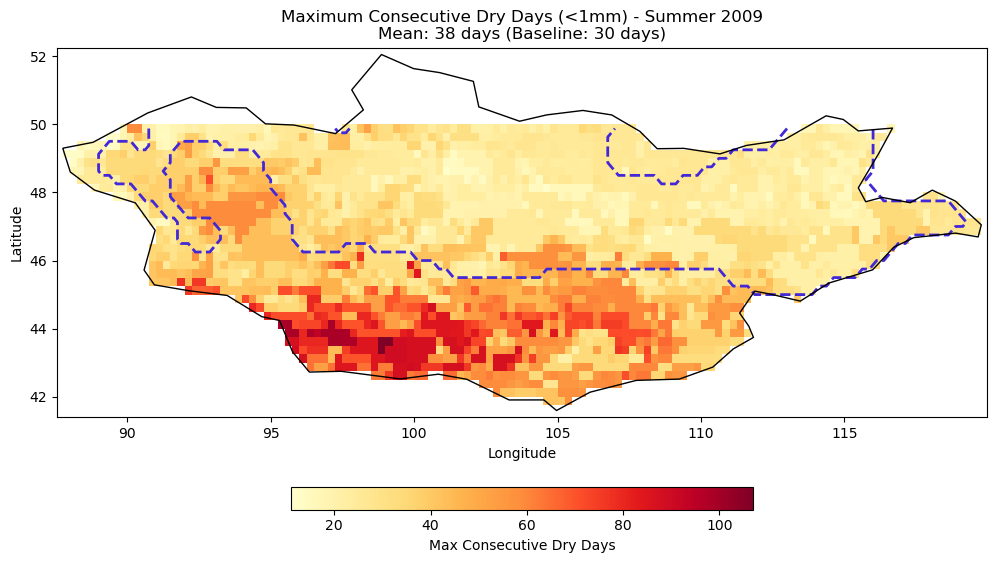

In [22]:
dry_threshold = 1.0

precip_2009_filled = summer_2009["precip"].fillna(9999.0)
dry_mask_2009 = precip_2009_filled < dry_threshold

dry_spell_2009 = xr.apply_ufunc(
    max_run_length,
    dry_mask_2009,
    input_core_dims=[["time"]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[int]
)

dry_spell_2009 = dry_spell_2009.compute()
dry_spell_2009 = dry_spell_2009.astype(np.float32)

dry_spell_2009 = dry_spell_2009.rio.write_crs("EPSG:4326")
dry_spell_2009_clip = dry_spell_2009.rio.clip(
    mongolia_shape.geometry,
    mongolia_shape.crs,
    drop=True
)

dry_spell_baseline_years = []
for year in range(1981, 2009):
    year_data = summer_baseline.sel(time=summer_baseline.time.dt.year == year)
    if len(year_data.time) == 0:
        continue
    dry_mask_year = year_data["precip"] < dry_threshold
    
    dry_spell_year = xr.apply_ufunc(
        max_run_length,
        dry_mask_year,
        input_core_dims=[["time"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[int]
    )
    dry_spell_baseline_years.append(dry_spell_year)

dry_spell_baseline = xr.concat(dry_spell_baseline_years, dim="year").mean(dim="year")
dry_spell_baseline = dry_spell_baseline.compute()
dry_spell_baseline = dry_spell_baseline.astype(np.float32)

dry_spell_baseline = dry_spell_baseline.rio.write_crs("EPSG:4326")
dry_spell_baseline_clip = dry_spell_baseline.rio.clip(
    mongolia_shape.geometry,
    mongolia_shape.crs,
    drop=True
)

mean_2009 = float(dry_spell_2009_clip.mean())
max_2009 = int(dry_spell_2009_clip.max())
min_2009 = int(dry_spell_2009_clip.min())
mean_baseline = float(dry_spell_baseline_clip.mean())

dry_spell_2009_grazing = dry_spell_2009_clip.where(grazing_mask_smooth > 0.5)
dry_spell_baseline_grazing = dry_spell_baseline_clip.where(grazing_mask_smooth > 0.5)

mean_2009_grazing = float(dry_spell_2009_grazing.mean(skipna=True))
mean_baseline_grazing = float(dry_spell_baseline_grazing.mean(skipna=True))

print(f"Baseline (1981-2008) Average Max Dry Spell: {round(mean_baseline, 2)} days")
print(f"Summer 2009 Average Max Dry Spell: {round(mean_2009, 2)} days")
print(f"Difference: +{round((mean_2009 - mean_baseline), 2)} days")
print(f"\nMinimum 2009: {round(min_2009, 2)} days")
print(f"Maximum 2009: {round(max_2009, 2)} days")


print(f"\nGrazing Areas:")
print(f"    Baseline: {round(mean_baseline_grazing, 2)} days")
print(f"    2009: {round(mean_2009_grazing, 2)} days")
print(f"    Difference: {round((mean_2009 - mean_baseline_grazing), 2)} days")

fig, ax = plt.subplots(figsize=(12, 6))
im = dry_spell_2009_clip.plot(
    ax=ax,
    cmap="YlOrRd",
    add_colorbar=False
)

ax.contour(
    grazing_mask_smooth.x, 
    grazing_mask_smooth.y, 
    grazing_mask_smooth.values,
    levels=[0.5],
    colors="#4228d6",
    linewidths=2,
    linestyles="--"
)

mongolia_shape.boundary.plot(ax=ax, color="black", linewidth=1)

ax.set_title(
    f"Maximum Consecutive Dry Days (<1mm) - Summer 2009\n"
    f"Mean: {mean_2009:.0f} days (Baseline: {mean_baseline:.0f} days)",
    fontsize=12
)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_aspect("auto")

minx, miny, maxx, maxy = mongolia_shape.total_bounds
ax.set_xlim(minx - 0.2, maxx + 0.2)
ax.set_ylim(miny - 0.2, maxy + 0.2)

cbar = fig.colorbar(
    im,
    ax=ax,
    orientation="horizontal",
    pad=0.15,
    fraction=0.05,
    label="Max Consecutive Dry Days"
)
plt.show()

#### Interpretation

The map demonstrates that during the summer of 2009, the entire country experienced a varying amount of consecutive dry days, from 11 to 107. The vast majority of the longer dry spells are concentrated in the arid south of Mongolia, with the semi arid region still being dry however worse in this summer specifically. Within the pasture areas, shown with the blue dotted line, it is clearly highlighted the stress existing with 20-40 day dry spells throughout the course of the summer. Compared to the 30 year baseline the summer of 2009 has a ~25% increase in dry spell length, showing that the preconditioning of this summer would have more significantly impacted the dzud in the winter.

The significance of these longer dry spells is important as extended dry spells will mean that grass in pasture areas for the winter, especially those of the central and western parts of Mongolia, has grown worse thus making it more difficult for grazing during the already tough climate of the winter. The extended dry spells in the more nothern and eastern parts of the pasture land is also important, as livestock grazing worse during the summer will result in weakened livestock which are less hardy to the harsh climates they will experience throughout the winter grazing period. Overall, the 7.5 day average increase equates for one full week of less rain during the critical summer growth period, a value devastating for the grazing ecosystem that Mongolian livestock is reliant upon.

### Spatial SPI of Summer 2009

The Standardized Precipitation Index (SPI) is a widely used drought indicator that quantifies precipitation deficits relative to historical conditions. For agricultural and pastoral systems like those in Mongolia, the 3 month SPI (SPI3) is particularly relevant as it captures the cumulative moisture conditions that determine pasture growth and water availability during the critical summer grazing season.

In this analysis, SPI3 is calculated for July, August, and September 2009 by comparing the 3 month precipitation totals against the 1981-2008 baseline distribution. The selection of July-September is due to the significance of the end of the summer for biomass accumulation, highlighting the key rainfall metrics for the preconditioning of the summer. A gamma distribution is fitted to historical precipitation at each grid cell, which is then transformed to a standard normal distribution to produce SPI values. Negative values indicate drier than normal conditions, with values below -1.0, -1.5, and -2.0 representing moderate, severe, and extreme drought respectively.

The spatial pattern of SPI3 across Mongolia reveals which regions experienced the most significant precipitation deficits during the summer preceding the devastating 2009-2010 dzud, and how drought conditions evolved throughout the season. 

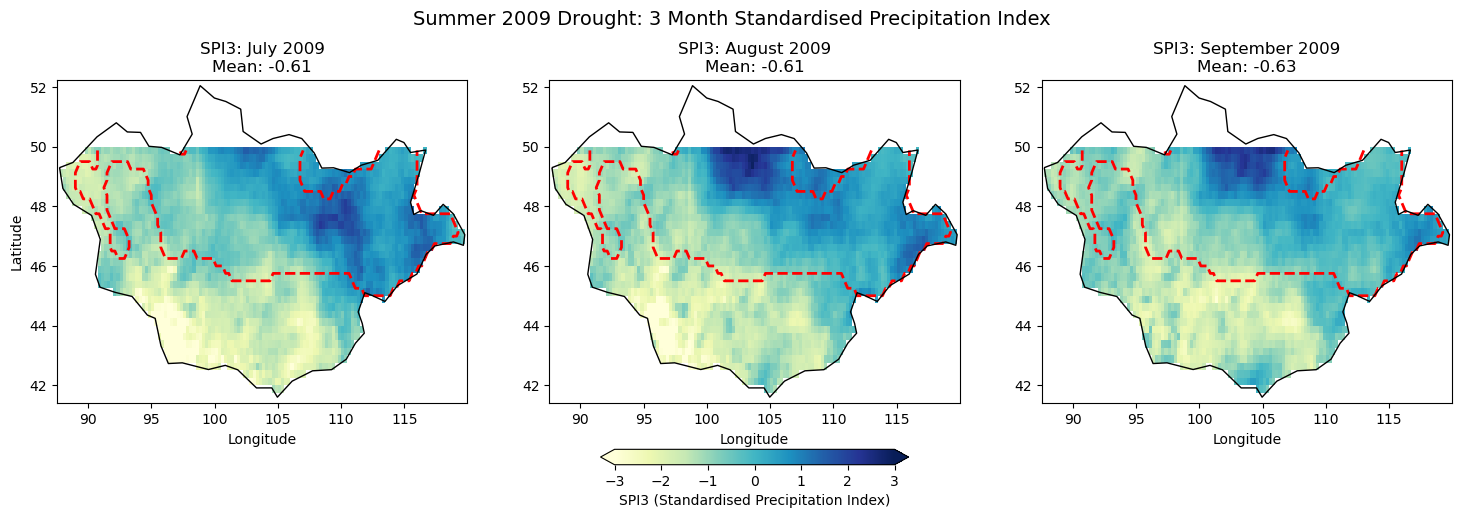

In [25]:
lat_min, lat_max = 41.0, 52.0
long_min, long_max = 87.0, 120.0

ds_2009_full = ds_summer_2009.sel(
    latitude=slice(lat_min, lat_max),
    longitude=slice(long_min, long_max)
)

ds_baseline_full = ds_chirps.sel(
    latitude=slice(lat_min, lat_max),
    longitude=slice(long_min, long_max)
)

spi3_2009 = {}

months_range = {
    7: (5, 6, 7),
    8: (6, 7, 8),
    9: (7, 8, 9)
}

for end_month, (m1, m2, m3) in months_range.items():
    mask = ds_2009_full.time.dt.month.isin([m1, m2, m3])
    spi3_2009[end_month] = ds_2009_full["precip"].sel(time=mask).sum(dim="time").compute()

spi3_baseline = {7: [], 8: [], 9: []}

for year in range(1981, 2009):
    year_data = ds_baseline_full.sel(time=ds_baseline_full.time.dt.year == year)

    for end_month, months in months_range.items():
        mask = year_data.time.dt.month.isin(months)
        precip_sum = year_data["precip"].sel(time=mask).sum(dim="time")
        spi3_baseline[end_month].append(precip_sum)
    
for month in [7, 8, 9]:
    spi3_baseline[month] = xr.concat(spi3_baseline[month], dim="year").compute()


def calculate_spi(precip_2009, precip_baseline):
    nlat, nlon = precip_2009.shape
    spi = np.full((nlat, nlon), np.nan, dtype=np.float32)

    for i in range(nlat):
        for j in range(nlon):
            hist_values = precip_baseline[:, i, j].values
            current_values = float(precip_2009[i, j].values)

            hist_values = hist_values[~np.isnan(hist_values)]

            if len(hist_values) < 10 or np.isnan(current_values):
                continue

            hist_nonzero = hist_values[hist_values > 0]

            if len(hist_nonzero) < 10:
                continue

            try:
                alpha, loc, beta = gamma.fit(hist_nonzero, floc=0)
                if current_values <= 0:
                    q = len(hist_values[hist_values == 0]) / len(hist_values)
                    probability = q / 2
                else:
                    q = len(hist_values[hist_values == 0]) / len(hist_values)
                    probability = q + (1-q) * gamma.cdf(current_values, alpha, loc=0, scale=beta)
                probability = np.clip(probability, 0.001, 0.999)
                spi[i, j] = stats_norm.ppf(probability)

            except Exception:
                continue
    return spi

spi_results = {}

for month in [7, 8, 9]:
    spi_values = calculate_spi(spi3_2009[month], spi3_baseline[month])

    spi_results[month] = xr.DataArray(
        spi_values,
        dims=["latitude", "longitude"],
        coords={
            "latitude": spi3_2009[month].latitude,
            "longitude": spi3_2009[month].longitude
        },
        name=f"SPI3_month{month}"
    )

for month in [7, 8, 9]:
    spi_results[month] = spi_results[month].astype(np.float32)
    spi_results[month] = spi_results[month].rio.write_crs("EPSG:4326")
    spi_results[month] = spi_results[month].rio.set_spatial_dims('longitude', 'latitude')
    spi_results[month] = spi_results[month].rio.clip(
        mongolia_shape.geometry,
        mongolia_shape.crs,
        drop=True
    )

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

month_names = {7: "July", 8: "August", 9: "September"}
spi_cmap = "YlGnBu"
vmin, vmax = -3, 3

for idx, month in enumerate([7,8,9]):
    ax = axes[idx]

    spi_data = spi_results[month]
    mean_spi = float(np.nanmean(spi_data.values))

    im = spi_data.plot(
        ax=ax,
        cmap=spi_cmap,
        vmin=vmin,
        vmax=vmax,
        add_colorbar=False
    )
    ax.contour(
        grazing_mask_smooth.x,
        grazing_mask_smooth.y,
        grazing_mask_smooth.values,
        levels=[0.5],
        colors="red",
        linewidths=2,
        linestyles="--"
    )

    mongolia_shape.boundary.plot(ax=ax, color="black", linewidth=1)

    ax.set_title(f"SPI3: {month_names[month]} 2009\nMean: {round(mean_spi, 2)}", fontsize=12)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude" if idx == 0 else "") 
    ax.set_aspect("auto")

    minx, miny, maxx, maxy = mongolia_shape.total_bounds
    ax.set_xlim(minx - 0.2, maxx + 0.2)
    ax.set_ylim(miny - 0.2, maxy + 0.2)

cbar = fig.colorbar(
    im,
    ax=axes,
    orientation="horizontal",
    pad=0.12,
    fraction=0.04,
    label="SPI3 (Standardised Precipitation Index)",
    extend="both"
)

plt.suptitle("Summer 2009 Drought: 3 Month Standardised Precipitation Index", fontsize=14, y=1.02)
plt.show()

#### Conclusion

The SPI3 analysis reveals that summer 2009 experienced mild but consistent precipitation deficits across Mongolia, with mean values around -0.6 for all three months. While these values fall within the "near normal" range (SPI > -1.0), several important patterns emerge:

**1. Spatial Heterogeneity**
- Western Mongolia shows the driest conditions (yellow/light areas, SPI approaching -1 to -2)
- Eastern Mongolia and parts of the northern grazing areas (within red dashed boundary) actually received near normal to slightly above normal precipitation (blue/green areas, SPI > 0)

**2. Not a Classic Drought Dzud**
The SPI-3 results suggest that the 2009-2010 dzud was not primarily driven by a severe summer drought as measured by standardised precipitation. This contrasts with the "classic" dzud pattern where severe summer drought leads to poor pasture conditions.

**3. Implications for the Dzud**
This suggests the 2009-2010 dzud was primarily a **"white dzud"** (driven by extreme winter conditions such as heavy snow, cold temperatures) rather than a **"black dzud"** (driven by summer drought and lack of pasture). The mild precipitation deficits may have contributed to slightly reduced pasture quality, but the devastating livestock losses were more attributable to the severity of the subsequent winter.

Despite these patterns suggesting that the 2009-2010 dzud was primarily a white dzud, the length of the dry spells suggests that the preconditioning was much more affected by timing and length than actual precipitation values. Because of this, to finalise the analysis of the summer preconditioning, I will analyse the timing of rainfall during the 2009 summer.

### Timing of Summer Rainfall in The Season

## Winter 2009-2010 Dzud Severity Analysis

## Seasonal Patterns and Compounding Risks

## Summary Statistics

## Conclusion and Next Steps